In [1]:
import pandas as pd
from os.path import join, isdir, exists, basename, dirname
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from icecream import ic
from src.utils import variant_utils as vu
from glob import glob
from itertools import product
from collections import defaultdict
from tqdm.notebook import tqdm
import pickle
from pandarallel import pandarallel

import mplh.cluster_help as ch

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
try:
    use_small = snakemake.params.get("use_small", False)
    to_plots = snakemake.params.get("to_plots", True)
    don_dir = snakemake.input["don_dir"]
    outdir = snakemake.params["outdir"]

    params = snakemake.config["mt_as_clones"]["params"]
    af_ts = params["af_ts"]
    oth_af_ts = params["oth_af_ts"]
    cov_ts = params["cov_ts"]
    oth_cov_ts = params["oth_cov_ts"]
    num_cells = params["num_cells"]
    oth_num_cells = params["oth_num_cells"]
    mean_pos_cov = params["mean_pos_cov"]
except NameError:
    use_small = False
    to_plots = True
    don_dir = ["/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_simpleUnion/donor0/",
               "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_simpleUnion/donor1/"]
    outdir = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_simpleUnion/mt_clones_thresh/scrap/donor0"
    d = 0
    af_ts = [0.01, 0.1, 0.4, 0.8, 0.95]
    oth_af_ts = [0.01, 0.1, 0.4, 0.8, 0.95]
    cov_ts = [2, 5, 10, 30] # mean coverage at position for cells with the AF
    oth_cov_ts = [2, 5, 10, 30]  # mean coverage for cells without AF 
    num_cells = [5, 10, 0.1, 0.2, 0.5 ] # num cells and fraction are for cells with sufficient coverage
    oth_num_cells = [0.25, 0.6, 0.8] # fraction is of cells with sufficient coverage
    mean_pos_cov = [0, 2, 5, 10] #populatiion average coverage at that position

In [4]:
minClusterSize=30
ncpus=12

In [5]:
pandarallel.initialize(nb_workers=ncpus)

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [6]:
objectives = ["n_vars_obs" , "n_cells_obs"] 
weights = [1,1]
param_objectives = ["cov", "oth_cov", "af", "oth_af", "ncells", "oth_ncells"]
param_weights = [1,1,1,-1,1,1 ]
dendro_objectives = ["variant_coefficient_variation"]
dendro_weights = [1]
# dendro_objectives = ["obj_nclones_more_than_one_unique", 
#                      "variants_with_clone_norm_by_1_over_nclones_with_variant", 
#                      "n_clones"]
# dendro_weights = [1,1, 1]

all_objectives = objectives+param_objectives+dendro_objectives
all_weights = weights+param_weights+dendro_weights

# all_objectives = objectives+param_objectives
# all_weights = weights+param_weights

all_weights

[1, 1, 1, 1, 1, -1, 1, 1, 1]

In [7]:
# There are 7 params to use for calling the clone
params = {"af":af_ts,
          "oth_af":oth_af_ts,
          "ncells": num_cells,
          "oth_ncells":oth_num_cells,
          "mean_cov": mean_pos_cov,
          "cov":cov_ts,
          "oth_cov":oth_cov_ts,
         }
param_names = params.keys()
full_params = list(product(*list(params.values())))
full_params = pd.DataFrame(full_params, columns=params.keys())
print(full_params.shape)
full_params.head()

(24000, 7)


af  oth_af  ncells  oth_ncells  mean_cov  cov  oth_cov
0  0.01    0.01     5.0        0.25         0    2        2
1  0.01    0.01     5.0        0.25         0    2        5
2  0.01    0.01     5.0        0.25         0    2       10
3  0.01    0.01     5.0        0.25         0    2       30
4  0.01    0.01     5.0        0.25         0    5        2

In [8]:
# cells_dir = join(outdir, "cells")
# if not exists(cells_dir):
#     os.mkdir(cells_dir)

In [9]:
#samples = samples.split(",")

In [10]:
#don_dirs = [d for d in glob(don_dir + "/donor*") if isdir(d)]
don_dirs = {int(basename(dirname(x)).split("donor")[-1]):dirname(x) for x in don_dir} #donor{d}/af.tsv

don_dirs

{0: '/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_simpleUnion/donor0',
 1: '/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_simpleUnion/donor1'}

In [11]:
def load_donor(don_dir):
    vcf = pd.read_csv(join(don_dir, "cellSNP.base.vcf"), sep="\t")
    variants_meta = vcf[["#CHROM", "POS", "REF", "ALT"]]
    variants_meta.index = variants_meta.apply(lambda x: f"{x['POS']}{x['REF'][0]}>{x['ALT']}", axis=1)
    variants_meta = vu.type_of_variants(variants_meta.index)
    variants_meta["ID"] = variants_meta.index
    variants_meta.index = variants_meta.apply(lambda x: f"{x['position']}{x['alt']}", axis=1)
    af = pd.read_csv(join(don_dir, "af.tsv"), sep="\t", index_col=0)
    cov = pd.read_csv(join(don_dir, "dp.tsv"), sep="\t", index_col=0)                   
    cells_meta = pd.read_csv(join(don_dir,"cells_meta.tsv"), sep="\t").set_index("ID")
    ic(cells_meta.shape)
    cells_meta = cells_meta.loc[af.index]
    ic("After filtering on af indices", cells_meta.shape)
    
    variants = set(af.columns)
    return af, cov, cells_meta, variants



## Informative variants function
#af	oth_af	ncells	oth_ncells	mean_cov	cov	oth_cov
def get_vars(thresholds, position_af, position_cov, return_cells=True):
    """ Sees if current position is an 'informative' variant using current thresholds
    """
    # preprocess ncells thresholds
    if thresholds["ncells"] < 1: #fraction of cells or total
        ncells = int(np.floor(thresholds["ncells"] * len(position_af)))
    else:
        ncells = thresholds["ncells"]
        
    # Get cells that pass af and coverage thresholds
    bin_position_af_cov = (position_af > thresholds["af"]) & (position_cov > thresholds["cov"])
    in_cells = bin_position_af_cov[bin_position_af_cov].index
    
    #print('bin_pos', bin_position_af_cov)
    #print(bin_position_af_cov.sum())
    
    if thresholds["oth_ncells"] < 1: # Fraction of the remaining population
        oth_ncells = int(np.floor(thresholds["oth_ncells"] * len(position_af)-len(in_cells)))
    else:
        oth_ncells = thresholds["oth_ncells"]    

    # positions that pass the coverage threshold but not the AF threshold. 
    # These are cells confidently not with variant, and oth_ncells needed to pass threshold.
    oth_bin_position_af_cov = (position_af <= thresholds["oth_af"]) & (position_cov > thresholds["oth_cov"])
    oth_bin_position_af_cov = oth_bin_position_af_cov.loc[~(oth_bin_position_af_cov.index.isin(in_cells))]
    
    if (bin_position_af_cov.sum() > ncells) & (oth_bin_position_af_cov.sum() > oth_ncells):
        if return_cells:
            return True, in_cells
        return True
    if return_cells:
        return False, []
    return False

def run_per_pos(af_cov, thresholds ,cov_id="COV-"):
    split = int(af_cov.shape[0]/2)
    af = af_cov.iloc[:split]
    cov = af_cov.iloc[split:]

    cov.index = [x.split(cov_id,1)[1] for x in cov.index]
    thresholds['isVar'] = thresholds.apply(get_vars, args=(af, cov), axis=1)
    thresholds["var"] = af_cov.name
    return thresholds


## Plot 
def plots(params_results, outdir, prefix):
    sns.histplot(params_results["n_vars"])

    cov_groups = params_results.groupby(["cov", "oth_cov", "mean_cov"])

    for ind, val in cov_groups:
        print(ind)
        sns.catplot(data=val, y="n_vars", x= "ncells", 
                    hue="af", row="oth_af", col="oth_ncells", kind="bar")
        plt.suptitle(f"{prefix} cov {ind[0]} oth_cov {ind[1]} mean_cov {ind[2]}")
        plt.tight_layout()
        plt.savefig(join(outdir,f"{prefix}_nvars_thresholds.cov_{ind[0]}_othcov_{ind[1]}_mean_{ind[2]}.png"))
    return

In [12]:
def get_cells(af, cov, oth_af, oth_cov, position_af, position_cov):
    """ Gets cells and oth_cells that pass thresholds. Assumes position already passed.
    """
    # Get cells that pass af and coverage thresholds
    bin_position_af_cov = (position_af > af) & (position_cov > cov)
    in_cells = bin_position_af_cov[bin_position_af_cov].index
    # positions that pass the coverage threshold but not the AF threshold. 
    # These are cells confidently not with variant, and oth_ncells needed to pass threshold.
    oth_bin_position_af_cov = (position_af <= oth_af) & (position_cov > oth_cov)
    # drop the cells
    oth_bin_position_af_cov = oth_bin_position_af_cov.loc[~(oth_bin_position_af_cov.index.isin(in_cells))]
    oth_cells = oth_bin_position_af_cov[oth_bin_position_af_cov].index
    return {"clone_cells": in_cells, "other_cells": oth_cells}

In [13]:
from src.clone_variants_optim import _objectives_dendro

from src.utils.dendro_clust import run_dynamic

from icecream import ic

### Approach:
1. for each parameter run evaluate_series
2. Create a df of mt-by-cells all as 0. 
3. Loop through each variant and run get_vars_and_cells . This takes one variant, the af and cov of that variant, and returns a dictionary of {v:[cells]}, where cells have the variant with right af and coverage 
4. The dictionary is used to fill in the binary df
5. After loop, remove cells and variants with all 0. 
6. create objective score df with weights and 0 as scores
6. Calculate nvars, ncells by the shape and add to objective
7. objectives_params: adds params objectives to the df
8. cluster with jaccard (issue for many 0's?) and run dynamic tree
9. run dendro_objectives, which uses many of the ones from the clone-vars-table.
10. Return the objectives_params, and the df (with the labels meta) if return_date=True.


In [14]:
def create_dendro(df, minClusterSize=30):
    ic('df', df.head())
    clusters, link = run_dynamic(df, metric="jaccard", minClusterSize=minClusterSize)
    
    ic(clusters.head())
    return clusters.drop("ID", axis=1).groupby("labels").size(), clusters

def calc_objectives(df):
    return {"n_cells_obs": df.shape[0], "n_vars_obs": df.shape[1]}

def calc_param_objectives(val, params_objectives_l):
    obj_params = {}
    for p in params_objectives_l:
        obj_params[p] = val[p]
    return obj_params

def get_binary_df(val, curr_af, curr_cov):
    bin_df = pd.DataFrame(np.zeros(curr_af.shape), index=curr_af.index, columns=curr_af.columns).astype(bool)
    thresh = [val["af"], val["oth_af"], val["cov"], val["oth_cov"]]
    #c_vars_df = pd.DataFrame(index=curr_af.o)
    for c_var in curr_af.columns:
        #print('c_val', c_var)
        pos_af = curr_af[c_var]
        pos_cov = curr_cov[c_var]
        isVar, cells = get_vars(val, pos_af, pos_cov, return_cells=True)
        if isVar:
            bin_df.loc[cells, c_var] = True
    # create binarized mt-cell df and calculate the dendro objectives 
    print('before remove 0 filter', bin_df.shape)

    bin_df = bin_df.loc[~((bin_df==0).all(axis=1)), ~((bin_df==0).all(axis=0))]
    print('after', bin_df.shape)
    #params_results.loc[ind,"Variants"] = ";".join(curr_vars)
    return bin_df


def calc_cv_objective(bin_df):
    af_var = bin_df.var()
    af_mean = bin_df.mean()
    return {"cv": (af_var/af_mean).sum()}

def evaluate_series(val, curr_af, curr_cov, return_data=True, get_dendro="cv", minClusterSize=30):
    bin_df = get_binary_df(val, curr_af, curr_cov)
    obj_dendro = {}
    if get_dendro == "dynamic":
        clusters_df, clusters = create_dendro(bin_df, minClusterSize=minClusterSize)
        ic(clusters_df.head())
        #ic((clusters_df>1).sum())
    elif get_dendro == "cv":
        obj_dendro = calc_cv_objective(bin_df)
    ic(bin_df.shape)
    ic(bin_df.head())
    
    # Objectives for nvars and nclones
    obj_bin = calc_objectives(bin_df)
    ic(obj_bin)
    # Parameter objectives - max/min parameter values
    obj_params = calc_param_objectives(val, param_objectives)
    ic(obj_params)
    obj = {}
    for i in [obj_bin, obj_params, obj_dendro]:
        for o in i:
            obj[o] = i[o]
    if return_data:
        out = {"objectives":pd.Series(obj), "binary_df": bin_df}
        if get_dendro=="dynamic":
            out["dendro_clust_df"] = clusters_df
            out["dendro_clust_labels"] = clusters
        return out
    return pd.Series(obj)

In [15]:
# for d in don_dirs: 
#     print('d', d)
#     curr_af, curr_cov, curr_cells_meta, curr_variants = load_donor(don_dirs[d])
#     if curr_af.shape[0] == 0:
#         continue
#     curr_cov_name = curr_cov.copy()   
#     curr_cov_name.index = "COV-" + curr_cov.index
#     curr_af_cov = pd.concat([curr_af, curr_cov_name], verify_integrity=True, sort=False)

#     if use_small: 
#         curr_af_cov = pd.concat([curr_af.iloc[:100,:100], curr_cov_name.iloc[:100,:100]], verify_integrity=True, sort=False)
#         full_params_df = full_params.iloc[:100]
#     else:
#         full_params_df = full_params.copy()
#     #curr_af_cov.apply(run_per_pos, args=(full_params_df,),expand=True)
#     all_passed_vars = defaultdict(list)
#     params_results = full_params_df.copy()
#     params_results["Variants"] = None

In [16]:
import src.clone_variants_optim as optim

In [17]:
d = 0

In [18]:
ic.disable()
#for d in don_dirs: 
curr_af, curr_cov, curr_cells_meta, curr_variants = load_donor(don_dirs[d])
# if curr_af.shape[0] == 0:
#     continue
curr_cov_name = curr_cov.copy()   
curr_cov_name.index = "COV-" + curr_cov.index
curr_af_cov = pd.concat([curr_af, curr_cov_name], verify_integrity=True, sort=False)

if use_small: 
    curr_af_cov = pd.concat([curr_af.iloc[:100,:100], curr_cov_name.iloc[:100,:100]], verify_integrity=True, sort=False)
    full_params_df = full_params.iloc[:100]
else:
    full_params_df = full_params.copy()

print('full_params_df', full_params_df.shape)

# results_df = full_params_df.sample(30).parallel_apply(evaluate_series, args=(curr_af, curr_cov, False, "cv"), axis=1)
# print((results_df>0).any())
# drop_inds = results_df.loc[(results_df==0).all(axis=1)].index
# results_norm = optim.set_multi(results_df, all_weights)
# rank_df = optim.set_multi_rank(results_norm, all_weights)

# drop_results = results_norm.loc[results_norm["multi"].isnull()]
# results_norm = results_norm.loc[~(results_norm["multi"].isnull())]

if full_params_df.shape[0]>=10000:
    results_df = full_params_df.sample(10000).parallel_apply(evaluate_series, args=(curr_af, curr_cov, False, "cv"), axis=1)
else:
    results_df = full_params_df.parallel_apply(evaluate_series, args=(curr_af, curr_cov, False, "cv"), axis=1)
#results_df = full_params.sample(100).parallel_apply(evaluate_series, args=(AF_df, DP_df, curr_labels), axis=1)

results_df.to_csv(join(outdir, "objectives.csv"))
full_params_df.to_csv(join(outdir, "raw_params.csv"))


#print(results_df.head())
print((results_df>0).any())
drop_inds = results_df.loc[(results_df==0).all(axis=1)].index



full_params_df (24000, 7)
before remove 0 filter (7002, 196)
after (7002, 37)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
before remove 0 filterafter  (7002, 196)(7002, 30)

after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (2254, 38)
before remove 0 filter (7002, 196)
after (4647, 6)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (6972, 18)
after (7002, 29)
before remove 0 filter (7002, 196)
after (6984, 41)
before remove 0 filter (7002, 196)
after (7002, 37)
before remove 0 filter (7002, 196)
after (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 28)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)after
 (6983, 30)
afterafter  (0, 0)(7002, 28)

before remove 0 filter (7002, 196)
after (1025

before remove 0 filter (7002, 196)
after (6983, 30)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (5036, 85)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (6975, 30)
after (7002, 29)before remove 0 filter
 (7002, 196)
after (4343, 34)
before remove 0 filter (7002, 196)
after (7002, 31)
before remove 0 filter (7002, 196)
after (6974, 19)
before remove 0 filter (7002, 196)
after (7002, 89)
before remove 0 filterbefore remove 0 filter  (7002, 196)(7002, 196)

before remove 0 filter (7002, 196)afterafter
  (6986, 196)
(7002, 68)
after (6976, 33)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (54, 3)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (6986, 89)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 31)
before remove 

before remove 0 filter (7002, 196)
after (7002, 35)
before remove 0 filter (7002, 196)
after (6964, 23)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (0, 0)
after (7002, 29)
before remove 0 filter (7002, 196)
after (6973, 19)
before remove 0 filter (7002, 196)
afterbefore remove 0 filterbefore remove 0 filter   (7002, 29)(7002, 196)(7002, 196)


after (7002, 30)
after (4261, 7)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (6972, 18)
before remove 0 filter (7002, 196)
after (5014, 23)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (4347, 39)
after (7002, 33)
before remove 0 filter (7002, 196)
after (5011, 23)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filt

before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (4280, 6)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (0, 0)
after (4280, 8)
before remove 0 filter (7002, 196)
after (6984, 39)
before remove 0 filter (7002, 196)
after (4261, 1)
before remove 0 filter (7002, 196)
after (7002, 34)
before remove 0 filter (7002, 196)
after (6981, 29)
before remove 0 filter (7002, 196)
after (5026, 30)
before remove 0 filter (7002, 196)
after (6977, 45)
before remove 0 filter (7002, 196)
after (7002, 34)
before remove 0 filter (7002, 196)
after (6980, 29)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)before remove 0 filter
 (7002, 196)
after (4261, 1)
after (7002, 29)
before remove 0 filter (7002, 196)
after (3922, 39)
before remove 0 filter (7002, 196)
after (4296, 3)
before remove 0 filter (7002, 196)
after (6972, 18)
before remove 0 filter (7

after (6974, 21)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
after (6981, 29)
before remove 0 filter (7002, 196)
after (4280, 6)
before remove 0 filter (7002, 196)
after (6983, 30)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)after
 (6977, 45)
after (5026, 30)
before remove 0 filter (7002, 196)
after (4260, 1)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (6974, 19)
after (4992, 29)
before remove 0 filter (7002, 196)
after (7002, 49)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (4292, 11)
before remove 0 filter (7002, 196)
after (4261, 1)
before remove 0 filter (7002, 196)
after (7002, 196)
before remove 0 filter (7002, 196)
after (5014, 23)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
after (6975, 29)
before remove 0 filter (7002, 196)
after (7002, 59)
before remove 0 filter (7002, 196)
before remove 0 filter

before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
afterbefore remove 0 filter  (7002, 196)(4261, 1)

after (6983, 38)
before remove 0 filter (7002, 196)
after (5022, 36)
before remove 0 filter (7002, 196)
after (4992, 33)
before remove 0 filter (7002, 196)
after (7002, 49)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after before remove 0 filter(7002, 30) 
(7002, 196)
after (6976, 35)
before remove 0 filter (7002, 196)
after (6972, 18)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 68)
after (6973, 19)
before remove 0 filter (7002, 196)
after (6975, 29)
before remove 0 filter (7002, 196)
after (7002, 39)
before remove 0 filter (7002, 196)
after (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
before remove 0 filterafter  (7002, 196)(7002, 35)

after (1770, 9)
before remove 0 filter (7002, 196)
afterbefore remove 0 filter (4

before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
afterafter (6964, 21) 
(7002, 50)
after (6982, 30)
before remove 0 filter (7002, 196)
after (6983, 31)
before remove 0 filter (7002, 196)
after (7002, 68)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after before remove 0 filter(6982, 30) (7002, 196)

after (7002, 30)
before remove 0 filter (7002, 196)
after (6983, 36)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (6981, 29)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (6983, 30)
after (6977, 23)
before remove 0 filter (7002, 196)
after (6971, 18)
before remove 0 filter (7002, 196)
after (7002, 68)
before remove 0 filter (7002, 196)
after (6973, 28)
before remove 0 filter (7002, 196)
after (7002, 46)
before remove 0 filter (7002, 196)
after (7002, 89)
before remove 0 filter (7002, 196)
after (6981, 29)
before remov

before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (5026, 30)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (6981, 29)
before remove 0 filter (7002, 196)
after (7002, 69)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (4260, 1)
before remove 0 filter (7002, 196)
after (5022, 36)
before remove 0 filter (7002, 196)
after (5026, 38)
before remove 0 filter (7002, 196)
after (7002, 35)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after after(6983, 36) 
(6978, 32)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after before remove 0 filter(0, 0) 
(7002, 196)
after (7002, 28)
before remove 0 filter (7002, 196)
after (6972, 18)
before remove 0 filter (7002, 196)
after (7002, 61)
before remove 0 filte

after (6980, 29)
before remove 0 filter (7002, 196)
after (6981, 29)
before remove 0 filter (7002, 196)
after (5014, 23)
before remove 0 filter (7002, 196)
after (6976, 34)
before remove 0 filter (7002, 196)
after (6972, 18)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 31)
before remove 0 filter (7002, 196)
after (6976, 35)
before remove 0 filter (7002, 196)
after (7002, 31)
before remove 0 filter (7002, 196)
afterbefore remove 0 filter  (7002, 30)(7002, 196)

after (2240, 33)
before remove 0 filter (7002, 196)
after (7002, 31)
before remove 0 filter (7002, 196)
after (159, 6)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 28)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (6977, 45)
before remove 0 filter (7002, 196)
after (4992, 34)
before remove 0 filterbefore remove 0 filter  (7002, 196)(7002, 196)

after (7002, 196)after
 (7002, 

after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 52)
before remove 0 filter (7002, 196)
after (7002, 59)
before remove 0 filter (7002, 196)
after (4977, 19)
before remove 0 filter (7002, 196)
after (7002, 49)
before remove 0 filter (7002, 196)
after (6976, 34)
before remove 0 filter (7002, 196)
after (7002, 31)
before remove 0 filter (7002, 196)
after (6976, 35)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (4681, 6)
before remove 0 filter (7002, 196)
after (7002, 35)
before remove 0 filter (7002, 196)
after (4261, 1)
before remove 0 filter (7002, 196)
after (7002, 28)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
after (6983, 30)
before remove 0 filter (7002, 196)
after (6981, 29)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (6973, 28)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 29)
after (7002, 29)
b

before remove 0 filter (7002, 196)
after (678, 32)
before remove 0 filter (7002, 196)
after (4288, 2)
before remove 0 filter (7002, 196)
after (4502, 40)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (6973, 28)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (4261, 1)
after (7002, 28)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (1557, 1)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after before remove 0 filter(7002, 30) 
(7002, 196)
after (7002, 35)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
afterafter  (4347, 39)(7002, 29)

before remove 0 filter (7002, 196)
after (4687, 7)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)after
 before remove 0 filter(7002, 68) 
(7002, 196)
after (7002, 69)
after (6984, 31)
before remove 0 f

before remove 0 filter (7002, 196)
after (6983, 30)
before remove 0 filter (7002, 196)
before remove 0 filterafter  (7002, 196)(6983, 36)

before remove 0 filter (7002, 196)
after (6982, 30)
after (6983, 38)
before remove 0 filter (7002, 196)
after (7002, 58)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (6981, 29)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (6972, 18)
before remove 0 filter (7002, 196)
before remove 0 filterafter  (7002, 196)(4291, 2)

after (6972, 18)
before remove 0 filter (7002, 196)
after (7002, 68)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (6982, 30)
before remove 0 filter (7002, 196)
after (6983, 36)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove

before remove 0 filterafter  (6983, 30)(7002, 196)

after (7002, 37)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)before remove 0 filter
 (7002, 196)
afterafter after (4991, 28)(0, 0) 

(7002, 30)
before remove 0 filter (7002, 196)
after (7002, 28)
before remove 0 filter (7002, 196)
after before remove 0 filter(6984, 39) 
(7002, 196)
after (3349, 26)
before remove 0 filter (7002, 196)
after (7002, 37)
before remove 0 filter (7002, 196)
after (6986, 196)
before remove 0 filter (7002, 196)
afterbefore remove 0 filter  (7002, 37)(7002, 196)

after (0, 0)
before remove 0 filter (7002, 196)
after (7002, 39)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (6971, 18)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 29)
after (7002, 29)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (5026, 38)
after (4263, 2)
before remove 0 filter (7002, 196)
after (6976, 35)
bef

after (6982, 30)
after (6961, 15)
before remove 0 filter (7002, 196)
after (6983, 30)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
after (7002, 38)
before remove 0 filter (7002, 196)
afterbefore remove 0 filter  (0, 0)(7002, 196)

after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 31)
before remove 0 filter (7002, 196)
after (122, 5)
before remove 0 filter (7002, 196)
after (7002, 37)
before remove 0 filter (7002, 196)
before remove 0 filterafter  before remove 0 filter(7002, 196)(7002, 39) 

(7002, 196)
afterafter  (7002, 28)(7002, 68)

before remove 0 filter (7002, 196)
after (7002, 37)
before remove 0 filter (7002, 196)
after (4280, 6)
before remove 0 filter (7002, 196)
after (1126, 6)
before remove 0 filter (7002, 196)
after before remove 0 filter(0, 0) 
(7002, 196)
after (6983, 30)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (4260

after (5014, 23)
before remove 0 filter (7002, 196)
after (4292, 10)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 31)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (6982, 30)
before remove 0 filter (7002, 196)
after (7002, 37)
before remove 0 filter (7002, 196)
after (5022, 36)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 31)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 39)
before remove 0 filter (7002, 196)
after (6975, 28)
before remove 0 filter (7002, 196)
after (4347, 39)
before remove 0 filter (7002, 196)
after (6979, 57)
before remove 0 filter (7002, 196)
after (4288, 2)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 39)
before remove 0 filter (7002, 196)
after (5022, 30)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 50)
after (5026, 

after (7002, 30)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 28)
after (7002, 31)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (6975, 29)
before remove 0 filter (7002, 196)
after (7002, 68)
before remove 0 filter (7002, 196)
after (7002, 69)
before remove 0 filter (7002, 196)
before remove 0 filter after(7002, 196) 
(7002, 29)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 28)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (1312, 7)
before remove 0 filter (7002, 196)
before remove 0 filterafter  (6983, 36)(7002, 196)

after (7002, 37)
before remove 0 filter (7002, 196)
after (6979, 57)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)before remove 0 filter 
(7002, 196)
after (7002, 28)
after (103, 3)after
 (6983, 38)
before remove 0 filter (7002, 196)before remove 0 

before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (4261, 1)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 68)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
before remove 0 filterafter  (7002, 196)(7002, 29)

after after(6980, 29) 
(7002, 28)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (4261, 1)
before remove 0 filter (7002, 196)
afterbefore remove 0 filter  (7002, 30)(7002, 196)

after (7002, 28)
before remove 0 filter (7002, 196)
after (6976, 34)
before remove 0 filter (7002, 196)
after (6973, 28)
before remove 0 filter (7002, 196)
after (6981, 29)
before remove 0 filter (7002, 196)
after (7002, 28)
before remove 0 filter (7002, 196)
before remove 0 filter before remove 0 filter (7002, 196)(7002, 196)

after aftera

before remove 0 filter (7002, 196)
after (7002, 69)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
after (4288, 2)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (6983, 38)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)after
 (6981, 29)
after (7002, 37)
before remove 0 filter (7002, 196)
afterbefore remove 0 filter  (7002, 37)
(7002, 196)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (6974, 19)
after (7002, 35)
before remove 0 filter (7002, 196)before remove 0 filter
 (7002, 196)
after (7002, 35)
after (7002, 30)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 30)
after (7002, 89)
before remove 0 filter (7002, 196)
after (7002, 28)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (6983, 30)
after (4977, 19)
before remove 0 f

before remove 0 filter (7002, 196)
after (7002, 52)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
before remove 0 filter after(7002, 196) 
(7002, 30)
after (6972, 18)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (6984, 39)
after (6981, 29)
before remove 0 filter (7002, 196)
after (7002, 28)
before remove 0 filter (7002, 196)
after (6983, 30)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 68)
after (7002, 30)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 196)after
 (7002, 29)
before remove 0 filter (7002, 196)
after (6986, 68)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (0, 0)
after (5014, 23)
before remove 0 filter (7002, 196)
after (7002, 34)
before remove 0 filter (7002, 196)
after (6972, 18)
before remove 0 filter (7002, 196)
after (7002, 68)
before remove 0 filter (7002, 196)
after (7002, 34)
before remove 0

afterbefore remove 0 filter  (6983, 36)(7002, 196)

after (6972, 18)
before remove 0 filter (7002, 196)
after (7002, 35)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (6976, 30)
before remove 0 filter (7002, 196)
after (6972, 18)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 68)before remove 0 filter
 (7002, 196)after
 (7002, 30)
after (7002, 35)
before remove 0 filter (7002, 196)
after (5022, 34)
before remove 0 filter (7002, 196)
after (6982, 30)
before remove 0 filter (7002, 196)
after (7002, 68)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 30)
after (5036, 85)
after (7002, 61)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
after (6979, 57)
before remove 0 filter (7002, 196)
after (7002, 68)

before remove 0 filter (7002, 196)
after (4502, 40)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (6972, 18)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (6975, 29)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (6986, 89)
after (6981, 29)
before remove 0 filterbefore remove 0 filter  (7002, 196)(7002, 196)

before remove 0 filterbefore remove 0 filter  (7002, 196)after(7002, 196)
 
after(6983, 30) (7002, 30)

afterafter  (0, 0)
(0, 0)
before remove 0 filter (7002, 196)
after (7002, 31)
before remove 0 filter (7002, 196)
after (5022, 30)
before remove 0 filter (7002, 196)
after (7002, 36)
before remove 0 filter (7002, 196)
after (4502, 40)
before remove 0 filter (7002, 196)
before remove 0 filter after(7002, 196) 
(4569, 4)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 31)
before remove 0 filte

after (6973, 28)
after (7002, 39)
before remove 0 filter (7002, 196)
after (3922, 39)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
after (7002, 34)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 36)
before remove 0 filter before remove 0 filter(7002, 196) 
(7002, 196)
after (5022, 30)
after (5011, 23)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (6976, 35)after
 (6977, 29)
before remove 0 filter (7002, 196)
after (6972, 18)
before remove 0 filter (7002, 196)
after (7002, 69)
before remove 0 filter (7002, 196)
before remove 0 filterbefore remove 0 filter  (7002, 196)(7002, 196)
after
 (7002, 29)
after (6982, 30)
after (6980, 29)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (6978, 24)
before remove 0 filterbefore remove 0 filter  (7002, 196)(7002, 196)

after (7002, 28)

after (4280, 8)
after (7002, 30)
after (7002, 49)
after (7002, 28)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)after 
(7002, 30)
after (7002, 28)
before remove 0 filter (7002, 196)
after (7002, 35)
before remove 0 filter (7002, 196)
after (7002, 28)
before remove 0 filter (7002, 196)
after (5026, 30)
before remove 0 filter (7002, 196)
after (7002, 68)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
before remove 0 filterbefore remove 0 filter  (7002, 196)(7002, 196)
before remove 0 filter
 (7002, 196)
after (7002, 28)
afterafter  (5026, 30)(7002, 30)

after (7002, 61)
before remove 0 filter (7002, 196)
before remove 0 filter after(7002, 196) 
(7002, 29)
after (6983, 30)
before remove 0 filter (7002, 196)
after before remove 0 filter(7002, 29) 
(7002, 196)
after (7002, 28)
before remove 0 filter before remove 0 filter(7002, 196) 
(7002, 196)
afterafter  (6975, 29)(6982, 30)

b

before remove 0 filter (7002, 196)
after (7002, 35)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (678, 32)
before remove 0 filter (7002, 196)
after (6984, 31)
before remove 0 filter (7002, 196)
after (54, 3)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
after (7002, 39)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
after (7002, 28)
before remove 0 filter (7002, 196)
after (7002, 35)
before remove 0 filter (7002, 196)
after (6986, 196)
before remove 0 filter (7002, 196)
after (6986, 89)
before remove 0 filter (7002, 196)
after (7002, 31)
before remove 0 filter (7002, 196)
after (7002, 36)
before remove 0 filter (7002, 196)
after (122, 5)
before remove 0 filter (7002, 196)
after (6982, 30)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (4260, 1)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (70

before remove 0 filter (7002, 196)
after (4261, 1)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
after (7002, 39)
before remove 0 filter (7002, 196)
before remove 0 filterafter  (7002, 196)(7002, 89)

after (7002, 29)
before remove 0 filter (7002, 196)
after (6986, 68)
before remove 0 filter (7002, 196)
after (6965, 20)
before remove 0 filter (7002, 196)
after (6981, 29)
before remove 0 filter (7002, 196)
after (6976, 35)
before remove 0 filter (7002, 196)
after (6986, 68)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
after (7002, 37)
before remove 0 filter (7002, 196)
after (5022, 30)before remove 0 filter
 (7002, 196)
after (3922, 39)
before remove 0 filter (7002, 196)
after (4280, 6)
before remove 0 filter (7002, 196)
after (7002, 68)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (6982, 30)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
afte

after (7002, 31)
after (7002, 35)
before remove 0 filter (7002, 196)
after (7002, 39)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 30)
after (7002, 68)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 29)
after (4992, 33)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (6977, 29)
before remove 0 filter (7002, 196)
after (4260, 1)
before remove 0 filter (7002, 196)before remove 0 filter
 (7002, 196)
after before remove 0 filterafter(7002, 29) 
 (7002, 196)(7002, 28)

after (6983, 30)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (6983, 38)
before remove 0 filter (7002, 196)
after (6984, 39)
before remove 0 filter (7002, 196)
after (6982, 30)
before remove 0 filter (7002, 196)
after (7002, 37)
before remove 0 filter (7002, 196)
after (6986, 69)
before remove 0 filter (7002, 1

after (7002, 29)
before remove 0 filter (7002, 196)
after (5021, 29)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (5036, 63)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)after
 (6974, 19)
after (7002, 38)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 37)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 39)before remove 0 filter
 (7002, 196)
after (4264, 2)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (4992, 33)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 61)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 31)
after (7002, 29)
before remove 0 filter (7002, 196)
after (4992, 

after (7002, 30)before remove 0 filter
 (7002, 196)
after (4687, 7)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 30)
after (6975, 29)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (6982, 30)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 34)
before remove 0 filter (7002, 196)
after (7002, 68)
before remove 0 filter (7002, 196)
after (132, 3)
before remove 0 filter (7002, 196)
after (5014, 23)
before remove 0 filter (7002, 196)
after (6983, 31)
before remove 0 filterbefore remove 0 filter  (7002, 196)
(7002, 196)
after (7002, 30)
after (5014, 23)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 52)
be

before remove 0 filter (7002, 196)
after (4292, 11)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
after (4681, 6)
before remove 0 filter (7002, 196)
before remove 0 filterafter  (6986, 68)(7002, 196)

after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 69)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 37)
after (7002, 37)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (6986, 68)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (0, 0)
after (6986, 68)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (6986, 89)
before remove 0 filter (7002, 196)
after (4161, 1)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)after
 (4467, 3)
after (6972, 18)
before rem

before remove 0 filter (7002, 196)
after (7002, 31)
before remove 0 filter (7002, 196)
after (6982, 30)
before remove 0 filter (7002, 196)
after (6976, 35)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (5022, 34)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (6977, 45)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (6979, 57)
before remove 0 filter (7002, 196)
after (7002, 35)
before remove 0 filter (7002, 196)
after (5022, 36)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
after (6981, 29)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)after
 (6983, 30)
after before remove 0 filter(7002, 29

before remove 0 filter (7002, 196)
afterafter  (5014, 23)(7002, 58)

before remove 0 filter (7002, 196)
after (7002, 50)
before remove 0 filter (7002, 196)
after (6983, 30)before remove 0 filter
before remove 0 filter  (7002, 196)(7002, 196)

after (7002, 28)after
 (7002, 28)
before remove 0 filter (7002, 196)
after before remove 0 filter(6983, 30) 
(7002, 196)
after (4292, 11)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 31)
after (6971, 18)
before remove 0 filter (7002, 196)
before remove 0 filter after(7002, 196) 
(7002, 30)
after (7002, 29)
before remove 0 filter before remove 0 filter(7002, 196) 
(7002, 196)
afterafter  (6983, 30)
(6984, 41)
before remove 0 filter (7002, 196)
after (6954, 17)
before remove 0 filter (7002, 196)
after (6983, 36)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (6980, 29)
after (4288, 2)
before remove 0 filter (7002, 196)
after (116, 4)
before remove 0 filter (7002, 196)
before remove 0

before remove 0 filter (7002, 196)
after (6976, 35)
before remove 0 filter (7002, 196)before remove 0 filter
 (7002, 196)
afterafter  (0, 0)(0, 0)

before remove 0 filter (7002, 196)
after (6973, 28)
before remove 0 filter (7002, 196)
afterbefore remove 0 filter  (7002, 196)(7002, 30)

after before remove 0 filter(7002, 39) 
(7002, 196)
after (6961, 15)
before remove 0 filter (7002, 196)
after (5064, 196)
before remove 0 filter (7002, 196)
after (7002, 37)
before remove 0 filter (7002, 196)
after (2240, 33)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 37)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (6971, 18)
before remove 0 filter (7002, 196)
afterbefore remove 0 filter  (7002, 28)(7002, 196)

after (7002, 29)
before remove 0 filter (7002, 196)
after (4291, 2)
before remove 0 filter (7002, 196)
after (7002, 28)
before remove 0 filter (7002, 196)
after (6977, 31)
before remove 0 filt

after (7002, 62)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (5014, 23)
before remove 0 filter (7002, 196)
before remove 0 filterbefore remove 0 filter  (7002, 196)(7002, 196)

before remove 0 filter after (7002, 196)(4347, 39)

before remove 0 filter (7002, 196)after
after  (4161, 1)(7002, 29)

after (7002, 30)after
 (5022, 34)
before remove 0 filter (7002, 196)
after (6981, 29)
before remove 0 filter (7002, 196)
after (6964, 22)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 31)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 28)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 28)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 68)
after (4260, 1)
before remove 0 filter (7002, 196)
after (7002, 3

after (6953, 13)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (6972, 18)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 61)
before remove 0 filterbefore remove 0 filter  (7002, 196)(7002, 196)

afterbefore remove 0 filter (5014, 23) 
(7002, 196)
after (7002, 30)
after (7002, 31)
before remove 0 filter (7002, 196)
after (7002, 28)
before remove 0 filter (7002, 196)
after (6953, 13)
before remove 0 filter (7002, 196)
after (7002, 68)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)after
 (7002, 37)
after (6953, 13)
before remove 0 filter (7002, 196)
afterbefore remove 0 filter  (4291, 2)(7002, 196)

afterbefore remove 0 filter  (7002, 196)(7002, 196)

after (6983, 30)
before remove 0 filter (7002, 196)
after (6983, 36)
before remove 0 filter (7002, 196)
after (3591, 38)before remove 0 filter
 (7002, 196)
after (7002, 30)
before remove 0 filterbefore remove 0 filter  (

before remove 0 filter (7002, 196)
after (5026, 30)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
after (7002, 31)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (289, 9)
before remove 0 filter (7002, 196)
after (63, 2)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)after
 (6983, 36)
after (7002, 37)
before remove 0 filter (7002, 196)
after (4992, 33)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (5011, 23)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (678, 32)
before remove 0 filter (7002, 196)
after (7002, 35)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (6975, 29)
before remove 0 filter

before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (6971, 18)
after (6974, 19)
before remove 0 filter (7002, 196)
after (6983, 30)
before remove 0 filter (7002, 196)
after (3591, 38)
before remove 0 filter (7002, 196)
after (6971, 18)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 37)
before remove 0 filter (7002, 196)
after (7002, 28)
before remove 0 filter (7002, 196)
after (7002, 59)
before remove 0 filter (7002, 196)
after (6983, 30)
before remove 0 filter (7002, 196)before remove 0 filter
 (7002, 196)
after (698, 37)after
 (7002, 34)
before remove 0 filter (7002, 196)
after (5022, 36)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (163, 6)
before remove 0 filter (7002, 196)
after (7002, 28)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 29)
after (6974, 19)
before remove 0

before remove 0 filter (7002, 196)
after (7002, 39)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after after(7002, 30) 
(6971, 18)
before remove 0 filter (7002, 196)
after (6972, 18)
before remove 0 filter (7002, 196)
after (6980, 61)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
before remove 0 filterafter  (7002, 196)(7002, 37)

after (5026, 30)
before remove 0 filter (7002, 196)
after (7002, 196)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (6983, 30)
after (7002, 35)
before remove 0 filter (7002, 196)
after (5022, 30)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter before remove 0 filter(7002, 196) 
(7002, 196)
before remove 0 filterafter  (7002, 196)(7002, 30)
after
 (7002, 30)
after (7002, 37)
before remove 0 filter (7002, 196)
after (5014, 23)
before remove 0 filter (7002, 196)
after (6981, 29)
before remove 0 filter (7002, 196)
after (147, 4)
before remove 0 filte

before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 31)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (6975, 29)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (5036, 85)
before remove 0 filter (7002, 196)
after (5026, 30)
before remove 0 filter (7002, 196)
after (7002, 68)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 28)
before remove 0 filter (7002, 196)
after (6979, 57)
before remove 0 filter (7002, 196)
after before remove 0 filter(7002, 30) 
(7002, 196)
after (5014, 23)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (6963, 16)before remove 0 filter
 (7002, 196)
after (4261, 1)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove

before remove 0 filter (7002, 196)
after (1557, 1)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (4992, 34)
before remove 0 filter (7002, 196)
after (5022, 34)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)after
 (7002, 30)
after (7002, 196)
before remove 0 filter (7002, 196)
after (6983, 35)
before remove 0 filter (7002, 196)
after (7002, 34)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
before remove 0 filter after(7002, 196) 
(6976, 34)
after (5014, 23)
after (7002, 37)
before remove 0 filter (7002, 196)
after (4648, 14)
before remove 0 filter (7002, 196)
after (7002, 39)
before remove 0 filter (7002, 196)
after (4618, 41)
before remove 0 filter (7002, 196)
after (7002, 37)
before remove 0 filter (7002, 196)
after (3591, 38)
before remove 0 filter (7002, 196)
after (6983, 30)
before remove 0 filter (7002, 196)
after (6982, 30)
before remov

before remove 0 filter (7002, 196)
after (6975, 29)
before remove 0 filter (7002, 196)
after (7002, 36)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (4288, 2)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter before remove 0 filter(7002, 196) 
(7002, 196)
after after(4710, 39) 
(6954, 17)
before remove 0 filter (7002, 196)
after (6953, 13)
before remove 0 filter (7002, 196)
after (7002, 49)
before remove 0 filter (7002, 196)
after (6975, 29)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filterbefore remove 0 filter  (7002, 196)(7002, 196)

after (7002, 45)
after (7002, 28)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 30)
after (7002, 68)
before remove 0 filter (7002, 196)
after (6971, 18)
before remove 0 filter (7002, 196)
before remove 0 filterafter  (7002, 196)(7002, 29)

after (7002, 30)
before remove

after (7002, 36)after
 (5026, 30)
before remove 0 filter (7002, 196)
after (7002, 61)
before remove 0 filter (7002, 196)
afterbefore remove 0 filter  (7002, 36)(7002, 196)

after (6980, 29)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (4992, 29)
after (6971, 18)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (4288, 2)
before remove 0 filter (7002, 196)
before remove 0 filterafter  (7002, 196)(7002, 29)

after (6982, 30)
before remove 0 filterbefore remove 0 filter  (7002, 196)(7002, 196)

after (0, 0)
after (6981, 29)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (6984, 31)
before remove 0 filter (7002, 196)after
 (7002, 28)
after (4280, 6)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (6984, 41)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filterbefore remove 0 fi

after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (6972, 18)
before remove 0 filter (7002, 196)
after (6983, 38)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)after
 (6983, 36)
after (1025, 1)
before remove 0 filter (7002, 196)
after (6980, 29)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 28)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (6986, 196)
after (6986, 68)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (5026, 30)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (6984, 39)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
after (4292, 10)
before remove 0 filter (7002, 196)
after (6976, 35)
before remove 0 filter (7002, 196)
afterbefore remove 0 filter  (6972, 18)(7002, 196)

after (7002, 30)

before remove 0 filter (7002, 196)
after (6976, 23)
before remove 0 filter (7002, 196)
after (7002, 28)
before remove 0 filter (7002, 196)
after (6982, 30)
before remove 0 filter (7002, 196)before remove 0 filter
 (7002, 196)
after after(7002, 30) 
(6953, 13)
before remove 0 filter before remove 0 filter(7002, 196) 
(7002, 196)
after (6982, 30)after
 (7002, 29)
before remove 0 filter (7002, 196)
after (4268, 3)
before remove 0 filter (7002, 196)
after (6983, 30)
before remove 0 filter (7002, 196)
after (5021, 29)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 33)
after (0, 0)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (6973, 28)after
 (7002, 31)
after (6953, 13)
before remove 0 filter (7002, 196)
after (7002, 68)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)after
 (7002, 30)
after (6979, 57)
before remove 0 f

before remove 0 filter (7002, 196)
after (6976, 36)
before remove 0 filter (7002, 196)
after (7002, 50)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)after
 (7002, 30)
after before remove 0 filter(5021, 29) 
(7002, 196)
after (6972, 18)
before remove 0 filter (7002, 196)
after (6973, 28)
before remove 0 filter (7002, 196)
after (7002, 62)before remove 0 filter
 (7002, 196)
after (6972, 26)
before remove 0 filter (7002, 196)
after (7002, 39)
before remove 0 filter (7002, 196)
after (7002, 69)
before remove 0 filterbefore remove 0 filter  (7002, 196)
(7002, 196)
after after(6976, 33) 
(6974, 19)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
after (6974, 19)
before remove 0 filter before remove 0 filter(7002, 196) (7002, 196)

after (6974, 19)after
 (4293, 2)
before remove 0 filter (7002, 196)
after (6981, 29)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
afterbefore remove 0 filter  after(6961, 15)(7002, 

before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 30)
after (0, 0)
before remove 0 filter (7002, 196)
before remove 0 filterafter  (7002, 196)(6972, 22)

after (7002, 28)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (5026, 30)
before remove 0 filter (7002, 196)
after (5026, 30)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 31)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 30)after
 (4292, 11)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 37)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 68)
before remove 0 filter (7002, 196)
after before remove 0 filter(7002, 29)
 (7002, 196)
after (4261, 1)
before remove 0 filter (7002, 196)
after (6966, 21)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 f

before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 29)
after (6981, 29)
before remove 0 filter (7002, 196)
after (4773, 45)
before remove 0 filter (7002, 196)
after (4261, 1)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (6972, 18)
after (7002, 29)
before remove 0 filter (7002, 196)
after (6975, 20)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)after
 (7002, 31)
after (7002, 68)
before remove 0 filter (7002, 196)
after (4977, 19)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
after (7002, 45)
before remove 0 filter (7002, 196)
after (6980, 29)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
after (7002, 52)
before remove 0 filter (7002, 196)
after (6983, 30)
before remove 0 filter (7002, 196)
after (6981, 29)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)after
 (7002, 29)
after (0, 0)
before remove 0 filter (7

before remove 0 filter (7002, 196)
after (7002, 37)
before remove 0 filter (7002, 196)
after (6983, 30)
before remove 0 filter (7002, 196)
before remove 0 filter after(7002, 196) 
(0, 0)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 28)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (6972, 18)
before remove 0 filter (7002, 196)
after (4992, 33)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after after(4502, 40) 
(7002, 33)
before remove 0 filter (7002, 196)
after (132, 3)
before remove 0 filter (7002, 196)
after (7002, 28)
before remove 0 filter (7002, 196)
after (7002, 50)
before remove 0 filter (7002, 196)
before remove 0 filter before remove 0 filter(7002, 196) 
(7002, 196)
after after(6983, 30) (6971, 18)

after (6972, 18)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
after (5026, 38)
before remove 0 filter

before remove 0 filter (7002, 196)
after (4280, 6)
before remove 0 filter (7002, 196)
after (7002, 31)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 68)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (6975, 29)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (6986, 89)before remove 0 filter
 (7002, 196)
after (5026, 30)
after (7002, 31)
after (7002, 89)
before remove 0 filter (7002, 196)
after (6981, 29)
before remove 0 filter (7002, 196)
before remove 0 filterafter  (7002, 196)(3591, 38)

after (7002, 30)
before remove 0 filter (7002, 196)
after (6972, 18)
before remove 0 filter (7002, 196)
after (5026, 30)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (116, 4)
before remove 0

before remove 0 filter (7002, 196)
before remove 0 filterbefore remove 0 filter  (7002, 196)(7002, 196)

after (7002, 68)
before remove 0 filter after(7002, 196) after
(0, 0) 
(1175, 1)
after (6983, 30)
before remove 0 filter (7002, 196)
after (7002, 38)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (5026, 40)
before remove 0 filter (7002, 196)
after (6981, 29)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)after
 (4292, 10)
after (0, 0)
before remove 0 filter (7002, 196)
after (7002, 35)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 29)
after (7002, 29)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 39)
after (7002, 29)
before remove 0 filter (7002, 196)
before remove 0 filter after(7002, 196) 
(0, 0)
after (6983, 30)
before remove 0 filter (7002, 196)
after (4279, 2)
before remove 0 filter (70

before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
afterafter  (7002, 39)(6972, 18)

before remove 0 filter (7002, 196)
after (6975, 29)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filterbefore remove 0 filter  (7002, 196)(7002, 196)

afterafter  (7002, 30)(6975, 29)

before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 61)
before remove 0 filter (7002, 196)
after (5064, 196)
before remove 0 filter (7002, 196)
after (6983, 38)
before remove 0 filter (7002, 196)
after (5026, 30)
before remove 0 filter (7002, 196)
after (7002, 68)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 34)after
 (5026, 30)
before remove 0 filter (7002, 196)
after (6972, 18)
before remove 0 filter (7002, 196)
after before remove 0 filter(0, 0) 
(7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (3591, 38)
before remove 0

after (6983, 30)
after (7002, 31)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after after(7002, 35) 
(0, 0)
before remove 0 filter (7002, 196)
after (6974, 34)
before remove 0 filter (7002, 196)
after (6975, 22)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (1025, 1)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (5014, 23)
before remove 0 filter (7002, 196)
after (6979, 57)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (6974, 32)
before remove 0 filter (7002, 196)
after (6982, 30)
after (6971, 18)
before remove 0 filter (7002, 196)
after (6975, 29)
before remove 0 filter (7002, 196)
after (6982, 30)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
befo

before remove 0 filter (7002, 196)
after before remove 0 filter(7002, 30) 
(7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (6982, 30)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (5026, 30)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (6983, 30)
before remove 0 filter before remove 0 filter(7002, 196) (7002, 196)

afterafter  (0, 0)(7002, 29)

before remove 0 filter (7002, 196)
after (4188, 2)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (4291, 2)
before remove 0 filter (7002, 196)
after (148, 5)
before remove 0 filter (7002, 196)
after (6983, 30)
before remove 0 filter (7002, 196)
after (6974, 19)
before remove 0 filter (7002, 196)
after (7002, 31)
before remove 0 filter (

before remove 0 filter (7002, 196)
after (7002, 35)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
before remove 0 filter after(7002, 196) 
(7002, 39)
after (6983, 30)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)after
 before remove 0 filter(6954, 19) 
(7002, 196)
after (6975, 22)
after (7002, 58)after
 (7002, 33)
before remove 0 filter (7002, 196)
after (6982, 30)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 37)
before remove 0 filter (7002, 196)
after (5022, 30)before remove 0 filter
 (7002, 196)
after (5064, 196)
before remove 0 filter (7002, 196)
after (7002, 34)
before remove 0 filter (7002, 196)
after (6954, 19)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)after
 (5026, 30)
after (6981, 29)
before remove 0 filter before remove 0 filter(7002, 196) 
(7002, 196)
before remove 0 filter after(7002, 196) 
(697

before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 37)
before remove 0 filter (7002, 196)
after (2254, 38)
before remove 0 filter (7002, 196)
after (4977, 19)
before remove 0 filter (7002, 196)before remove 0 filter
 (7002, 196)
before remove 0 filter (7002, 196)
after after(7002, 29) 
(6983, 30)
after (1917, 1)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (5026, 38)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (6983, 30)after
 (4293, 2)
before remove 0 filter (7002, 196)
after (5064, 196)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (4260, 1)
before remove 0 filter (7002, 196)
before remove 0 filter after(7002, 196) 
(7002, 28)
after (6983, 30)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 1

before remove 0 filter (7002, 196)
after (6983, 30)
before remove 0 filterbefore remove 0 filter  (7002, 196)(7002, 196)

afterafter  (7002, 29)(7002, 29)

before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after before remove 0 filter(6986, 196) 
(7002, 196)
after (6972, 18)before remove 0 filter
 (7002, 196)
after (6980, 29)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (148, 5)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
after (7002, 28)
before remove 0 filter (7002, 196)
after (4688, 15)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 28)
after (7002, 29)
before remove 0 filter (7002, 196)
before remove 0 filterafter  (7002, 196)(7002, 30)

before remove 0 filter (7002, 196)after
 (7002, 36)
after (7002, 30)
before remove 0 filter (7002, 196)
after (6982, 30)
before remove 0 f

before remove 0 filter (7002, 196)
after (6971, 18)
before remove 0 filter (7002, 196)
after (7002, 68)
before remove 0 filter (7002, 196)
after (6983, 30)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (6986, 196)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (4260, 1)
before remove 0 filterbefore remove 0 filter (7002, 196) 
(7002, 196)
afterafter  (7002, 29)(6978, 32)

before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (5026, 30)
afterbefore remove 0 filter  (6983, 30)(7002, 196)

after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filterbefore remove 0 filter  (7002, 196)(7002, 196)

after (0, 0)
after (7002, 28)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 

after (7002, 30)
before remove 0 filter (7002, 196)
after (4288, 2)
before remove 0 filter (7002, 196)
after (4623, 12)
before remove 0 filter (7002, 196)
before remove 0 filterafter  (5036, 85)(7002, 196)

after (4347, 39)
before remove 0 filter (7002, 196)
afterbefore remove 0 filter  (7002, 30)(7002, 196)

after (7002, 49)
before remove 0 filter (7002, 196)
after before remove 0 filter(7002, 196) 
(7002, 196)
after (4260, 1)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 68)
after (4280, 8)
before remove 0 filter (7002, 196)
after (6975, 22)
before remove 0 filter (7002, 196)
after (6984, 39)
before remove 0 filter (7002, 196)
after (4991, 28)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 39)
before remove 0 filter (7002, 196)
after (6979, 57)
before remove 0 filter (7002, 196)
after (6972, 18)
before remove 0 filter (7002, 196)
after (6981, 2

before remove 0 filter (7002, 196)
after (5014, 23)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (4260, 1)
before remove 0 filter (7002, 196)
after (7002, 37)
after (7002, 29)
before remove 0 filter (7002, 196)
after (6954, 19)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 58)
before remove 0 filter (7002, 196)
after (6975, 30)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)before remove 0 filter 
(7002, 196)
after (7002, 34)
after (6986, 196)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (6976, 33)
before remove 0 filter (7002, 196)
after (6986, 196)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 31)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
after (7002, 39)
before remove 0

after (7002, 28)
before remove 0 filter (7002, 196)
after (281, 8)
before remove 0 filter (7002, 196)
after (6972, 18)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
afterbefore remove 0 filter  (7002, 196)(7002, 29)

after (6983, 30)
before remove 0 filter (7002, 196)
after (7002, 28)
before remove 0 filter (7002, 196)
before remove 0 filterafter  (7002, 196)(6986, 69)

after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (1770, 9)
before remove 0 filter (7002, 196)
after (5026, 30)
before remove 0 filter (7002, 196)
after (7002, 39)
before remove 0 filter (7002, 196)
after (5026, 30)
before remove 0 filter (7002, 196)
after (6983, 36)
before remove 0 filter (7002, 196)
after (7002, 52)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filterafter  (7002, 196)(7002, 30)

after (6983, 30)
before remove 0 filter (7002, 196)
after (4293, 2)
bef

before remove 0 filter (7002, 196)
afterbefore remove 0 filter  (7002, 196)(1917, 1)

before remove 0 filter (7002, 196)
after (7002, 30)
after (7002, 49)
before remove 0 filter (7002, 196)
after (6981, 29)
before remove 0 filter (7002, 196)
after (6973, 28)
before remove 0 filter (7002, 196)
after (6975, 20)
before remove 0 filter (7002, 196)
after (6976, 33)
before remove 0 filter (7002, 196)
after (6973, 27)
before remove 0 filter (7002, 196)
after (6971, 18)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
after (6981, 29)
before remove 0 filter (7002, 196)
after (4291, 2)
before remove 0 filter (7002, 196)
after (678, 32)
before remove 0 filter (7002, 196)
after (6983, 30)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
after (289, 9)
before remove 0 filter (7002, 196)
after (6975, 30)
before remove 0 filter (7002, 196)
after (6983, 30)
before remove 0 filter (7002, 196)
after (7002, 89)
before remove 0 filter (7

before remove 0 filter (7002, 196)
after (6981, 29)
before remove 0 filter (7002, 196)
after (7002, 62)
before remove 0 filter (7002, 196)
after (7002, 28)
before remove 0 filter (7002, 196)
after (7002, 31)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (6983, 30)
before remove 0 filter (7002, 196)
after (6976, 36)
before remove 0 filter (7002, 196)
after (7002, 196)
before remove 0 filter (7002, 196)
after (6975, 30)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 29)
after (6983, 35)
before remove 0 filter (7002, 196)
after (7002, 68)
before remove 0 filter (7002, 196)
afterbefore remove 0 filter  (7002, 39)(7002, 196)

before remove 0 filter (7002, 196)
after (7002, 35)
before remove 0 filter (7002, 196)after
 (7002, 29)
after (7002, 30)
before remove 0 filter (7002, 196)
after (6973, 28)
before remove 0 filter (7002, 196)
after (4268, 3)
before remove 0 filter (7002, 196)
after (7002, 30)
before remov

before remove 0 filter (7002, 196)
after (6972, 18)
before remove 0 filter (7002, 196)
after (5026, 30)
before remove 0 filter (7002, 196)
after (4991, 28)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)after
 (7002, 30)
after (1126, 6)
before remove 0 filter (7002, 196)
after (4261, 1)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 30)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 38)
before remove 0 filter before remove 0 filter(7002, 196)
 (7002, 196)before remove 0 filter 
(7002, 196)
before remove 0 filter (7002, 196)
afterafter  (6954, 19)(6983, 33)

afterafter  (7002, 28)(6983, 30)

before remove 0 filter (7002, 196)
before remove 0 filterafter  (7002, 196)(0, 0)

after (6983, 30)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (6986, 68)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)


before remove 0 filter (7002, 196)
after (6972, 18)
before remove 0 filter (7002, 196)
after (4260, 1)
before remove 0 filter (7002, 196)before remove 0 filter
 (7002, 196)
after (6983, 38)after
 (6983, 30)
before remove 0 filter (7002, 196)
after (7002, 49)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (109, 4)
before remove 0 filter (7002, 196)
after (7002, 68)before remove 0 filter
 (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (0, 0)
before remove 0 filter (7002, 196)
afterbefore remove 0 filter  (6972, 18)
(7002, 196)
after (7002, 28)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (0, 0)
after (6983, 30)
before remove 0 filter (7002, 196)before remove 0 filter
 (7002, 196)
after (6972, 18)
after (7002, 29)
before remove 0 filter (7002, 196)
after (7002, 68)
before remove 0 filterbefore remove 0 filter  (7002, 196)(7002, 196)

after after(7002, 61) 
(7002, 30)
before remove 0 filter 

before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (7002, 68)
before remove 0 filter (7002, 196)
after (7002, 31)
before remove 0 filter (7002, 196)
after (4683, 11)
before remove 0 filter (7002, 196)
after (6983, 30)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (5026, 30)
before remove 0 filter (7002, 196)
after (7002, 33)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
after (6975, 29)
before remove 0 filter (7002, 196)
after (4279, 2)
before remove 0 filter (7002, 196)
after (4260, 1)
before remove 0 filter (7002, 196)
after (6980, 29)
before remove 0 filter (7002, 196)
after (7002, 29)
before remove 0 filter (7002, 196)
before remove 0 filter (7002, 196)
after (7002, 30)
after (6975, 29)
before remove 0 filter (7002, 196)
after (7002, 34)
before remove 0 filter (7002, 196)
after (7002, 30)
before remove 0 filter (7002, 196)
after (6984, 41)
before remove 

(10000, 9)
objs_total n_cells_obs    60045799.00
n_vars_obs       335903.00
cov              119470.00
oth_cov          116044.00
af                 4555.02
dtype: float64


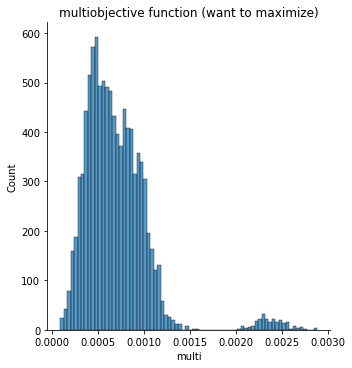

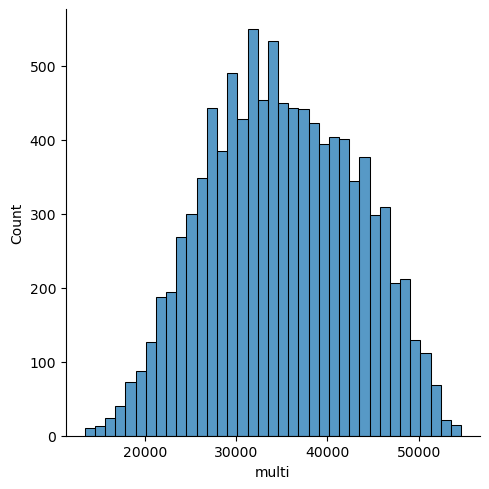

In [19]:
results_norm = optim.set_multi(results_df, all_weights)
rank_df = optim.set_multi_rank(results_norm, all_weights)

drop_results = results_norm.loc[results_norm["multi"].isnull()]
results_norm = results_norm.loc[~(results_norm["multi"].isnull())]
if len(results_norm) == 0:
    raise ValueError("No param retrieved variants")

########################
## Save the objective results
########################
results_norm.to_csv(join(outdir, "objectives_norm.csv"))

full_params.to_csv(join(outdir, "raw_params.csv"))
rank_df.to_csv(join(outdir, "objectives_rank.csv"))
#results_norm.loc[results_norm["multi"] == np.nan]
full_params.to_csv(join(outdir, "params.csv"))

########################
# Plot distribution results
########################
sns.displot(results_norm["multi"])
plt.title("multiobjective function (want to maximize)")
plt.savefig(join(outdir, "loss_multi.pdf"))

sns.displot(rank_df["multi"])


In [20]:
topn=16

In [37]:
filt_results.columns.isin(param_names)

array([False, False, False, False, False, False, False, False, False,
       False,  True,  True,  True,  True,  True,  True,  True])

In [101]:

########################
# Get the top n results
########################
def get_top_n_results(results_df, rank_df, n=12):
    filt_rank = rank_df.sort_values(by=["multi"])[::-1].iloc[:n]
    filt_results = results_df.loc[filt_rank.index]
    return filt_rank, filt_results


filt_rank, filt_results = get_top_n_results(results_norm, rank_df, n=topn)
filt_results.columns = [f"{x}_obj" for x in filt_results.columns]
obj_columns = filt_results.columns
filt_results = pd.merge(filt_results, full_params_df, left_index=True, right_index=True, how="left")
filt_rank = filt_rank.loc[filt_results.index]

filt_results["params"] = filt_results.apply(optim.params_to_str, axis=1, args=(param_names,))
filt_results["params_multi"] = filt_results.apply(optim.params_and_multi_str, axis=1)
filt_results.head()

all_df = []
all_objs = {}
for ind, val in filt_results.iterrows():
    print(ind)
    data = evaluate_series(val, curr_af, curr_cov, True, "cv")
    df = data["binary_df"]
    #df.index = [f"{ind}_{x}" for x in df.index]
    df["ID"] = ind
    all_df.append(df)
    all_objs[ind] = data["objectives"]
all_df = pd.concat(all_df).fillna(0)
all_df.index.name = "id"
all_df.columns.name = "variant"
all_df

19350
before remove 0 filter (7002, 196)
after (7002, 33)
19382
before remove 0 filter (7002, 196)
after (7002, 33)
19334
before remove 0 filter (7002, 196)
after (7002, 33)
14742
before remove 0 filter (7002, 196)
after (7002, 33)
14774
before remove 0 filter (7002, 196)
after (7002, 33)
14726
before remove 0 filter (7002, 196)
after (7002, 33)
20486
before remove 0 filter (7002, 196)
after (7002, 32)
20518
before remove 0 filter (7002, 196)
after (7002, 32)
19525
before remove 0 filter (7002, 196)
after (7002, 33)
19541
before remove 0 filter (7002, 196)
after (7002, 33)
5158
before remove 0 filter (7002, 196)
after (7002, 46)
5142
before remove 0 filter (7002, 196)
after (7002, 46)
19462
before remove 0 filter (7002, 196)
after (7002, 34)
19478
before remove 0 filter (7002, 196)
after (7002, 34)
19399
before remove 0 filter (7002, 196)
after (7002, 35)
19431
before remove 0 filter (7002, 196)
after (7002, 35)


variant                   13188T  1438G   73G  11453A  16362C  4769G  1413C  \
id                                                                            
AAACGAACAAGCGAAC-1_Flt3l    True   True  True   False    True   True  False   
AAACGAACACAGCCAC-1_Flt3l    True   True  True   False    True   True  False   
AAACGAACACAGGTAG-1_Flt3l    True  False  True   False   False  False  False   
AAACGAACATAGAATG-1_Flt3l   False   True  True   False    True   True  False   
AAACGAAGTATTCGAC-1_Flt3l   False   True  True   False    True   True  False   
...                          ...    ...   ...     ...     ...    ...    ...   
TTTGTGTGTAGGGTCA-1_Input    True   True  True   False    True   True      0   
TTTGTGTGTTTCTTAC-1_Input    True   True  True   False    True   True      0   
TTTGTGTTCCTGAAAC-1_Input    True   True  True   False    True   True      0   
TTTGTGTTCGGGAAAC-1_Input    True   True  True   False    True   True      0   
TTTGTGTTCTGGCACG-1_Input    True   True  True   False    True   True      0   

variant                   8292A  7028T  14766T  ...  11719A  11812G  3244A  \
id                                              ...                          
AAACGAACAAGCGAAC-1_Flt3l   True   True    True  ...       0       0      0   
AAACGAACACAGCCAC-1_Flt3l   True   True    True  ...       0       0      0   
AAACGAACACAGGTAG-1_Flt3l   True  False    True  ...       0       0      0   
AAACGAACATAGAATG-1_Flt3l   True  False    True  ...       0       0      0   
AAACGAAGTATTCGAC-1_Flt3l   True   True    True  ...       0       0      0   
...                         ...    ...     ...  ...     ...     ...    ...   
TTTGTGTGTAGGGTCA-1_Input   True   True    True  ...       0       0      0   
TTTGTGTGTTTCTTAC-1_Input   True   True    True  ...       0       0      0   
TTTGTGTTCCTGAAAC-1_Input   True   True    True  ...       0       0      0   
TTTGTGTTCGGGAAAC-1_Input   True   True    True  ...       0       0      0   
TTTGTGTTCTGGCACG-1_Input   True   True    True  ...       0       0      0   

variant                   15928A  709A  9899C   310C  15607G  2833G  14905A  
id                                                                           
AAACGAACAAGCGAAC-1_Flt3l       0     0      0      0       0      0       0  
AAACGAACACAGCCAC-1_Flt3l       0     0      0      0       0      0       0  
AAACGAACACAGGTAG-1_Flt3l       0     0      0      0       0      0       0  
AAACGAACATAGAATG-1_Flt3l       0     0      0      0       0      0       0  
AAACGAAGTATTCGAC-1_Flt3l       0     0      0      0       0      0       0  
...                          ...   ...    ...    ...     ...    ...     ...  
TTTGTGTGTAGGGTCA-1_Input       0     0      0   True       0      0       0  
TTTGTGTGTTTCTTAC-1_Input       0     0      0  False       0      0       0  
TTTGTGTTCCTGAAAC-1_Input       0     0      0  False       0      0       0  
TTTGTGTTCGGGAAAC-1_Input       0     0      0  False       0      0       0  
TTTGTGTTCTGGCACG-1_Input       0     0      0  False       0      0       0  

[112032 rows x 49 columns]

In [59]:
filt_results

n_cells_obs_obj  n_vars_obs_obj   cov_obj  oth_cov_obj    af_obj  \
19350         0.000117        0.000098  0.000042     0.000086  0.000209   
19382         0.000117        0.000098  0.000042     0.000086  0.000209   
19334         0.000117        0.000098  0.000042     0.000086  0.000209   
14742         0.000117        0.000098  0.000042     0.000086  0.000176   
14774         0.000117        0.000098  0.000042     0.000086  0.000176   
14726         0.000117        0.000098  0.000042     0.000086  0.000176   
20486         0.000117        0.000095  0.000042     0.000086  0.000209   
20518         0.000117        0.000095  0.000042     0.000086  0.000209   
19525         0.000117        0.000098  0.000042     0.000043  0.000209   
19541         0.000117        0.000098  0.000042     0.000043  0.000209   
5158          0.000117        0.000137  0.000042     0.000086  0.000022   
5142          0.000117        0.000137  0.000042     0.000086  0.000022   
19462         0.000117        0.000101  0.000042     0.000086  0.000209   
19478         0.000117        0.000101  0.000042     0.000086  0.000209   
19399         0.000117        0.000104  0.000042     0.000259  0.000209   
19431         0.000117        0.000104  0.000042     0.000259  0.000209   

       oth_af_obj  ncells_obj  oth_ncells_obj    cv_obj  multi_obj    af  \
19350    0.000002    0.000157        0.000146  0.000061   0.000913  0.95   
19382    0.000002    0.000157        0.000146  0.000061   0.000913  0.95   
19334    0.000002    0.000157        0.000146  0.000061   0.000913  0.95   
14742    0.000002    0.000314        0.000146  0.000055   0.001031  0.80   
14774    0.000002    0.000314        0.000146  0.000055   0.001031  0.80   
14726    0.000002    0.000314        0.000146  0.000055   0.001031  0.80   
20486    0.000022    0.000314        0.000146  0.000053   0.001039  0.95   
20518    0.000022    0.000314        0.000146  0.000053   0.001039  0.95   
19525    0.000002    0.000314        0.000146  0.000061   0.001027  0.95   
19541    0.000002    0.000314        0.000146  0.000061   0.001027  0.95   
5158     0.000002    0.000314        0.000146  0.000145   0.001006  0.10   
5142     0.000002    0.000314        0.000146  0.000145   0.001006  0.10   
19462    0.000002    0.000314        0.000109  0.000067   0.001042  0.95   
19478    0.000002    0.000314        0.000109  0.000067   0.001042  0.95   
19399    0.000002    0.000314        0.000045  0.000073   0.001160  0.95   
19431    0.000002    0.000314        0.000045  0.000073   0.001160  0.95   

       oth_af  ncells  oth_ncells  mean_cov  cov  oth_cov  
19350    0.01     5.0        0.80         2    5       10  
19382    0.01     5.0        0.80        10    5       10  
19334    0.01     5.0        0.80         0    5       10  
14742    0.01    10.0        0.80         2    5       10  
14774    0.01    10.0        0.80        10    5       10  
14726    0.01    10.0        0.80         0    5       10  
20486    0.10    10.0        0.80         0    5       10  
20518    0.10    10.0        0.80         5    5       10  
19525    0.01    10.0        0.80         0    5        5  
19541    0.01    10.0        0.80         2    5        5  
5158     0.01    10.0        0.80         5    5       10  
5142     0.01    10.0        0.80         2    5       10  
19462    0.01    10.0        0.60         0    5       10  
19478    0.01    10.0        0.60         2    5       10  
19399    0.01    10.0        0.25         0    5       30  
19431    0.01    10.0        0.25         5    5       30

In [103]:
row_clr_schemes = {p:"categorical" for p in param_names}
for o in obj_columns:
    row_clr_schemes[o] = "sequential"
row_clr_schemes


{'af': 'categorical',
 'oth_af': 'categorical',
 'ncells': 'categorical',
 'oth_ncells': 'categorical',
 'mean_cov': 'categorical',
 'cov': 'categorical',
 'oth_cov': 'categorical',
 'n_cells_obs_obj': 'sequential',
 'n_vars_obs_obj': 'sequential',
 'cov_obj': 'sequential',
 'oth_cov_obj': 'sequential',
 'af_obj': 'sequential',
 'oth_af_obj': 'sequential',
 'ncells_obj': 'sequential',
 'oth_ncells_obj': 'sequential',
 'cv_obj': 'sequential',
 'multi_obj': 'sequential'}

ind 5142


/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


ind 5158
ind 14726
ind 14742
ind 14774
ind 19334
ind 19350
ind 19382
ind 19399
ind 19431
ind 19462
ind 19478
ind 19525
ind 19541
ind 20486
ind 20518


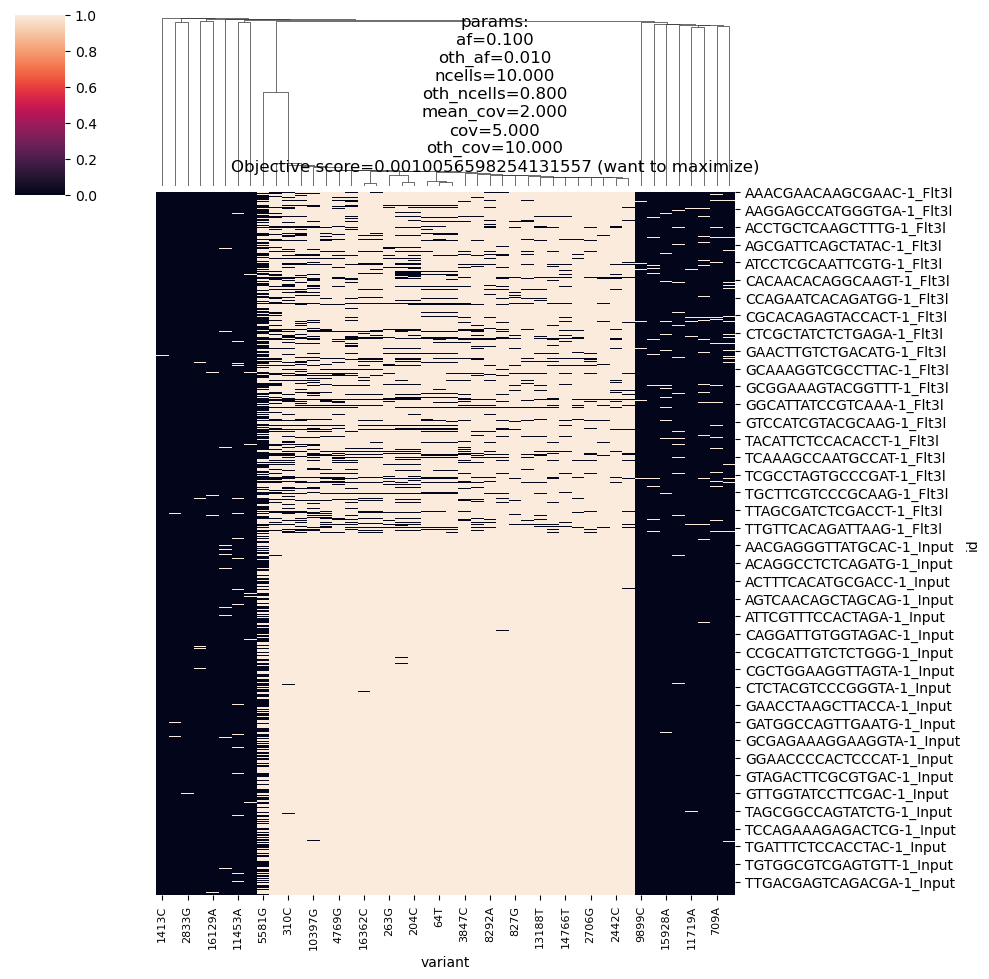

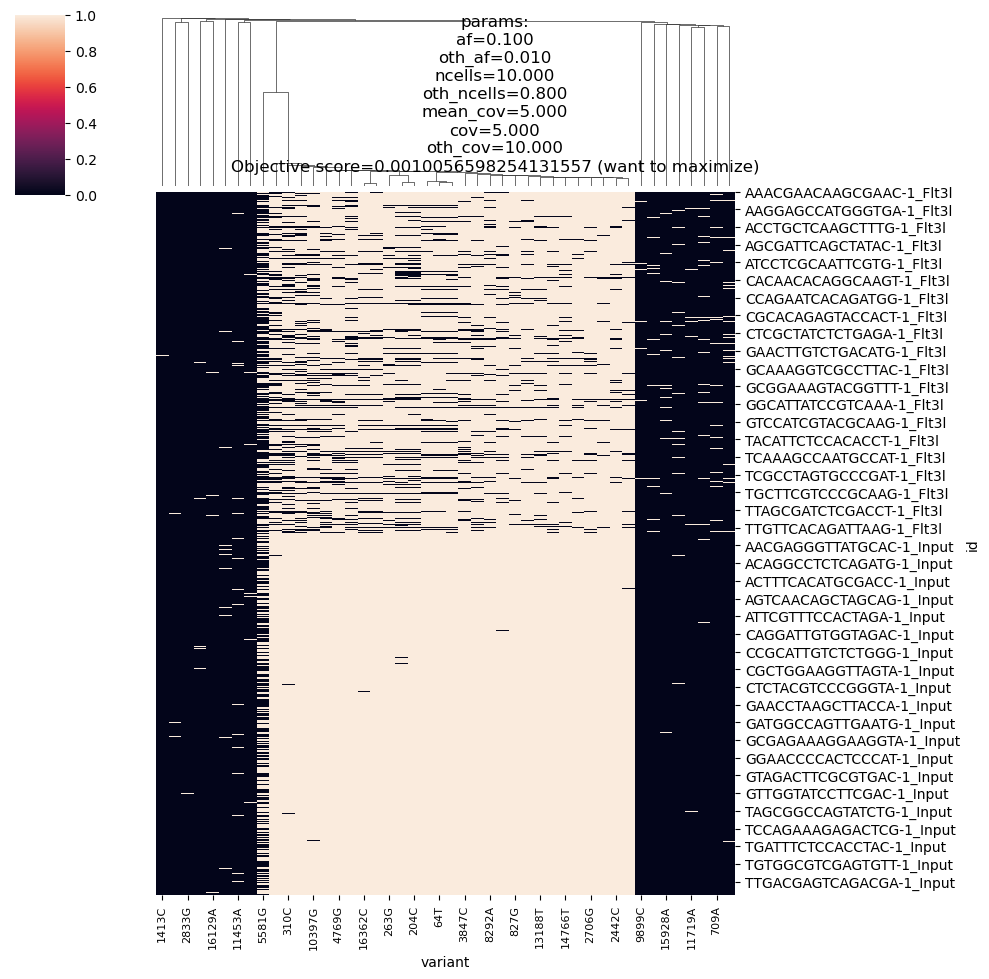

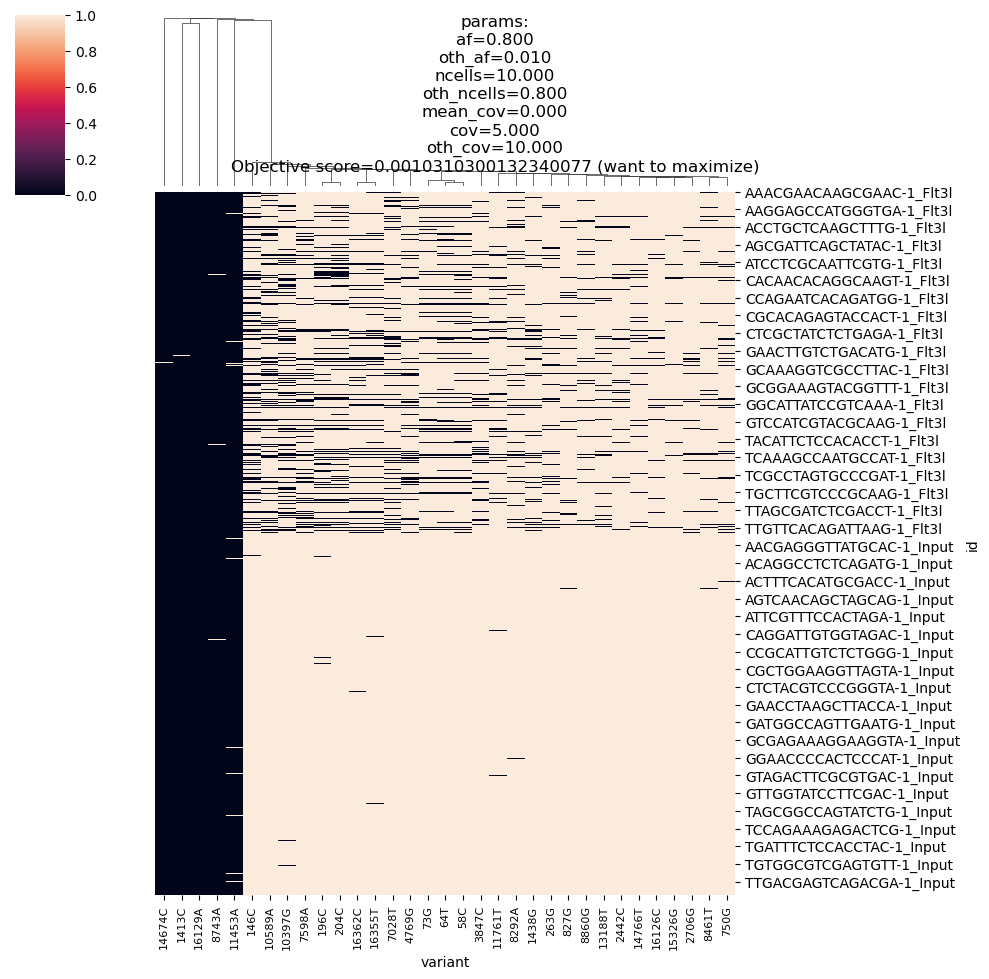

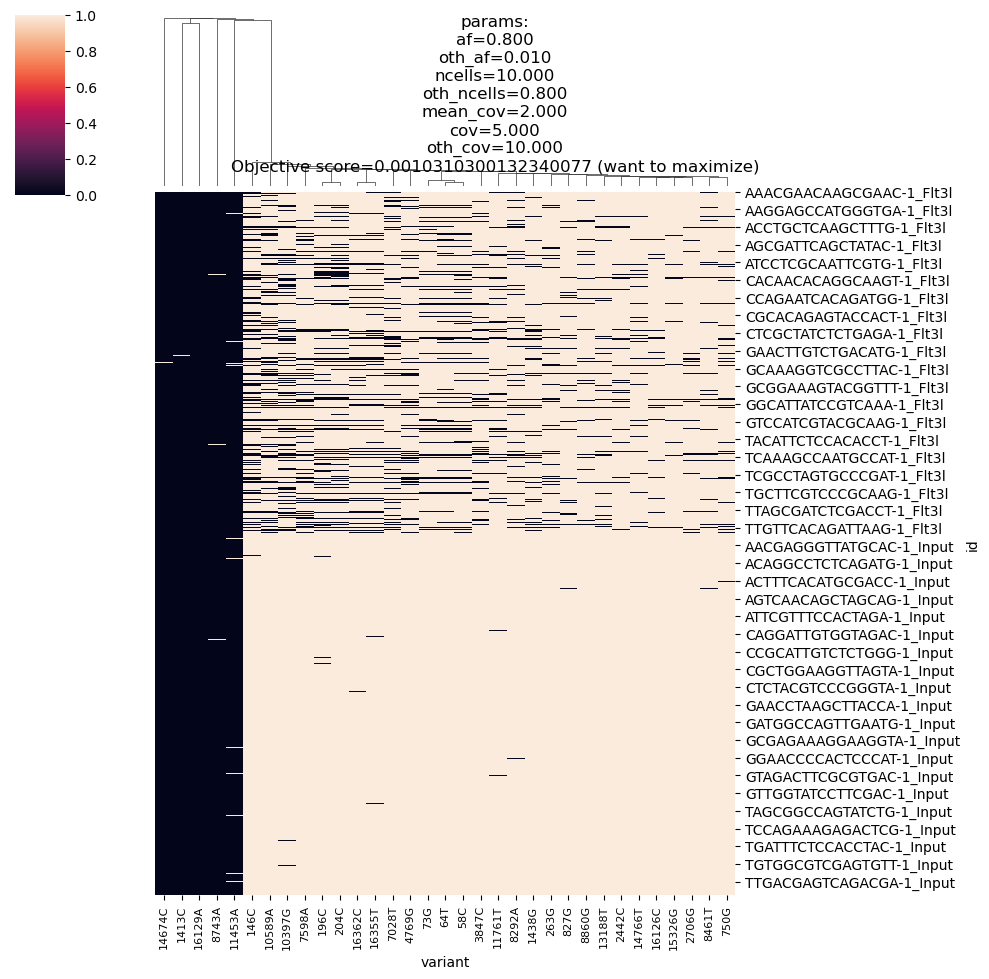

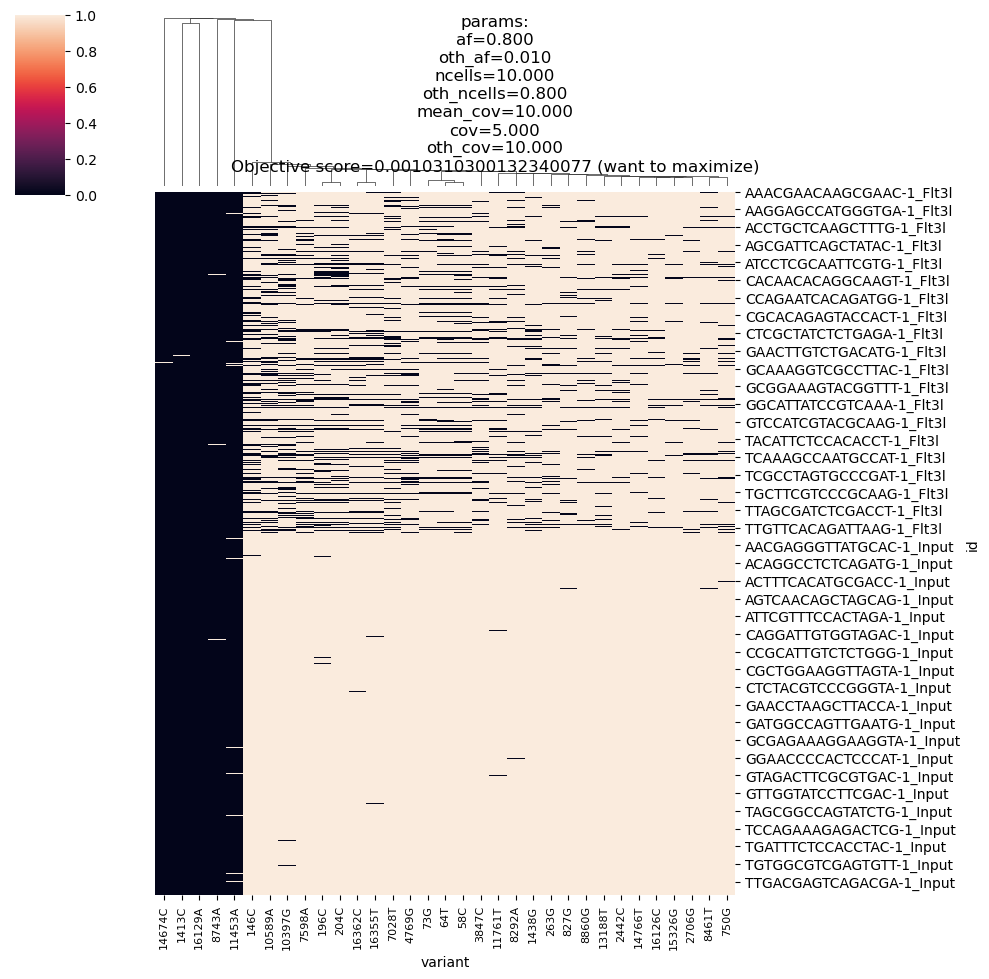

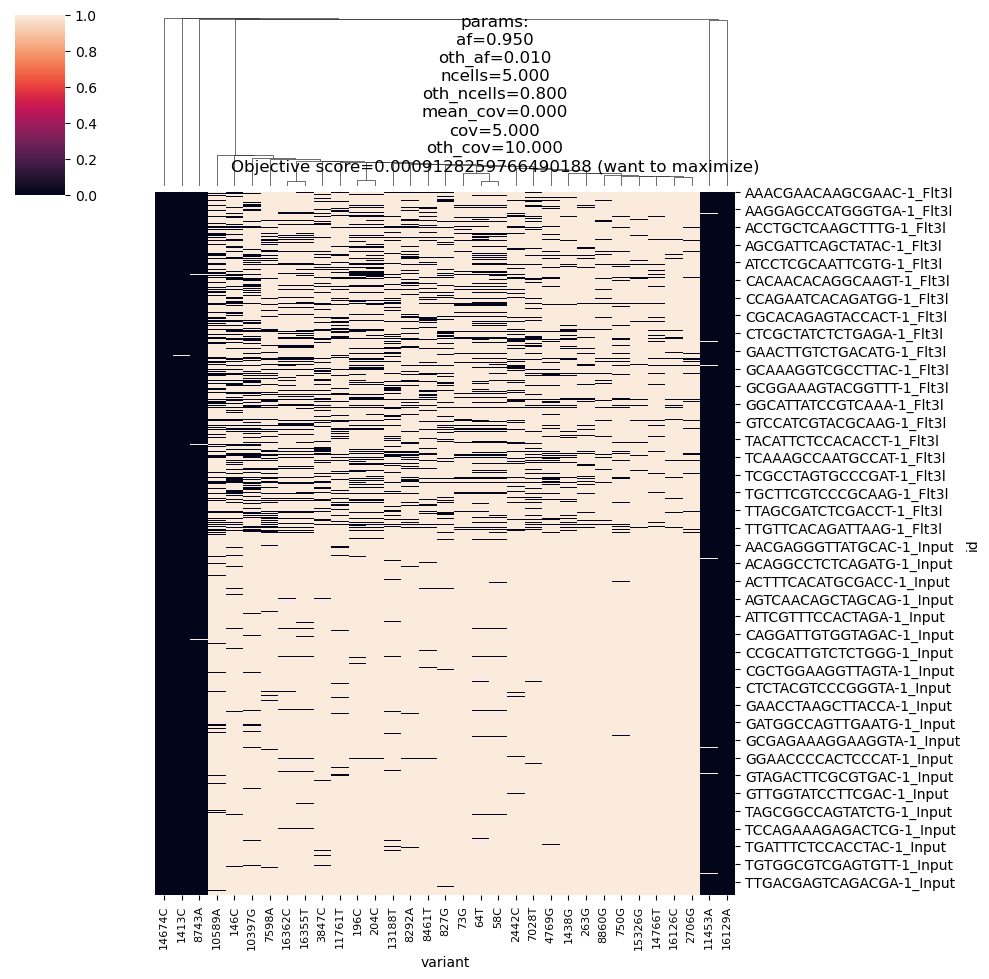

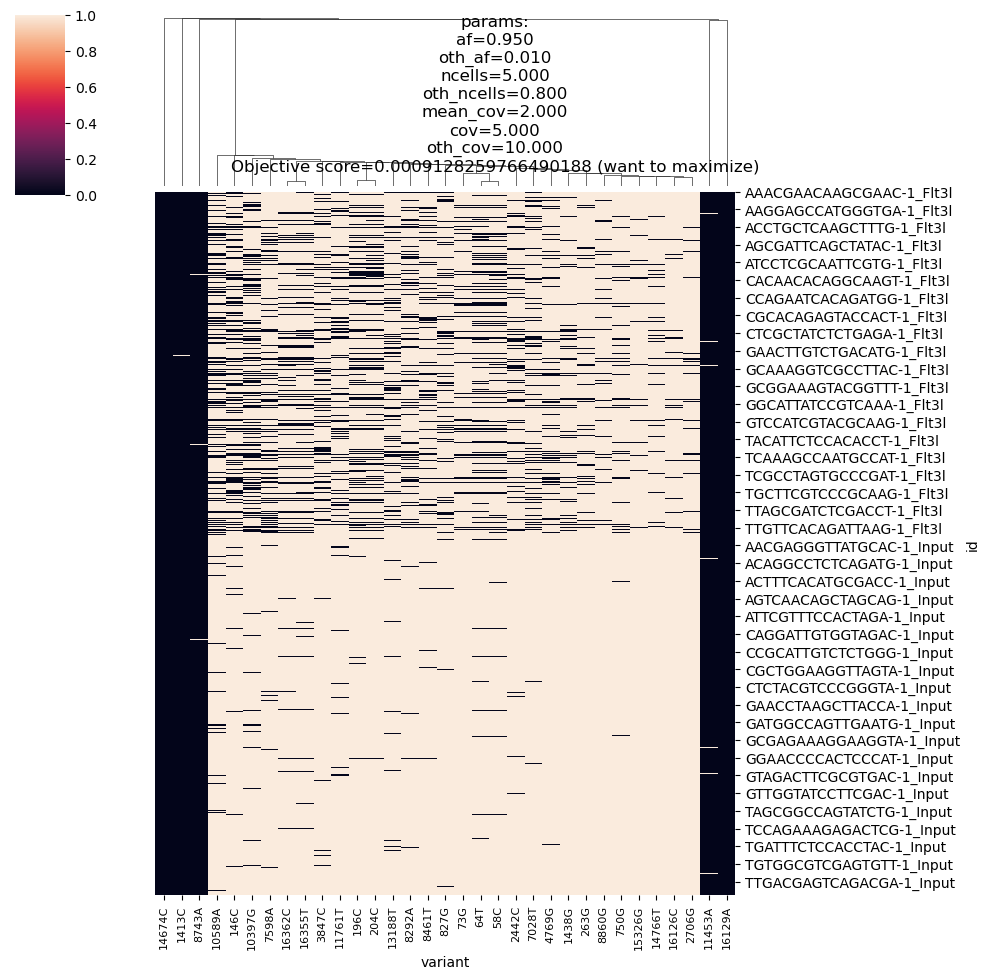

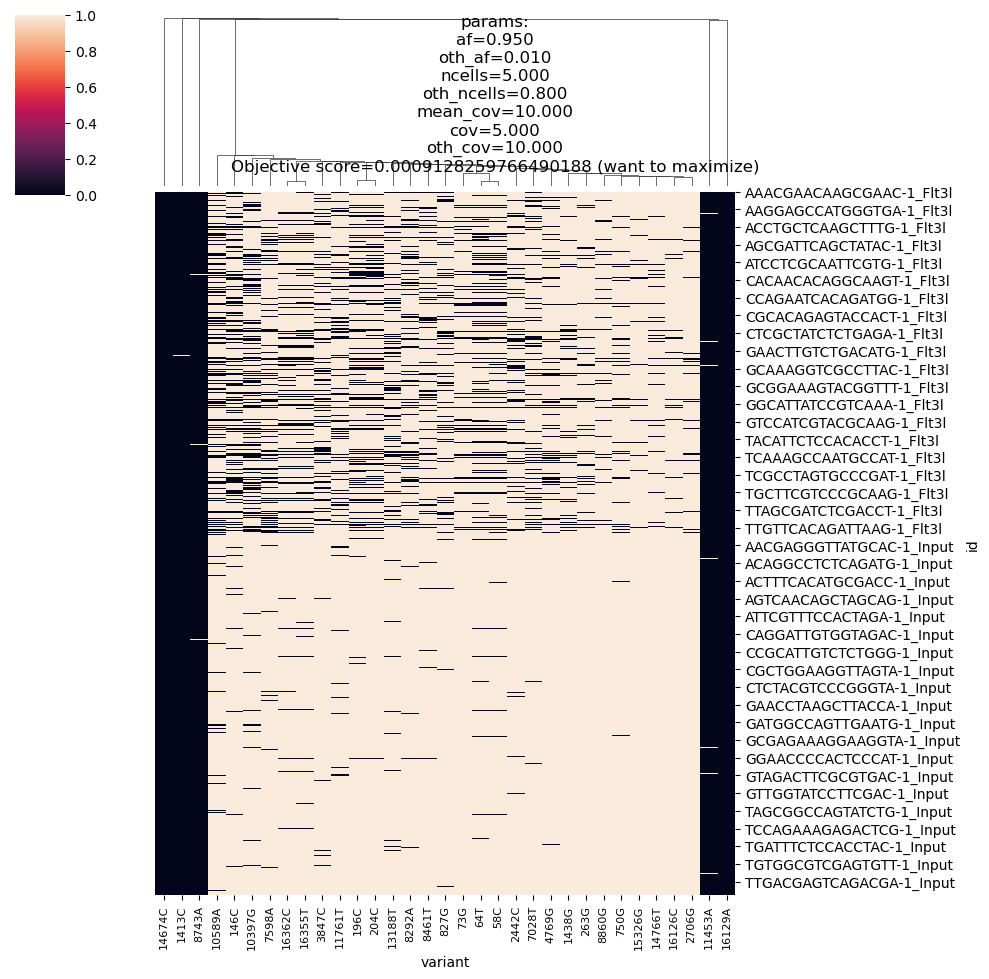

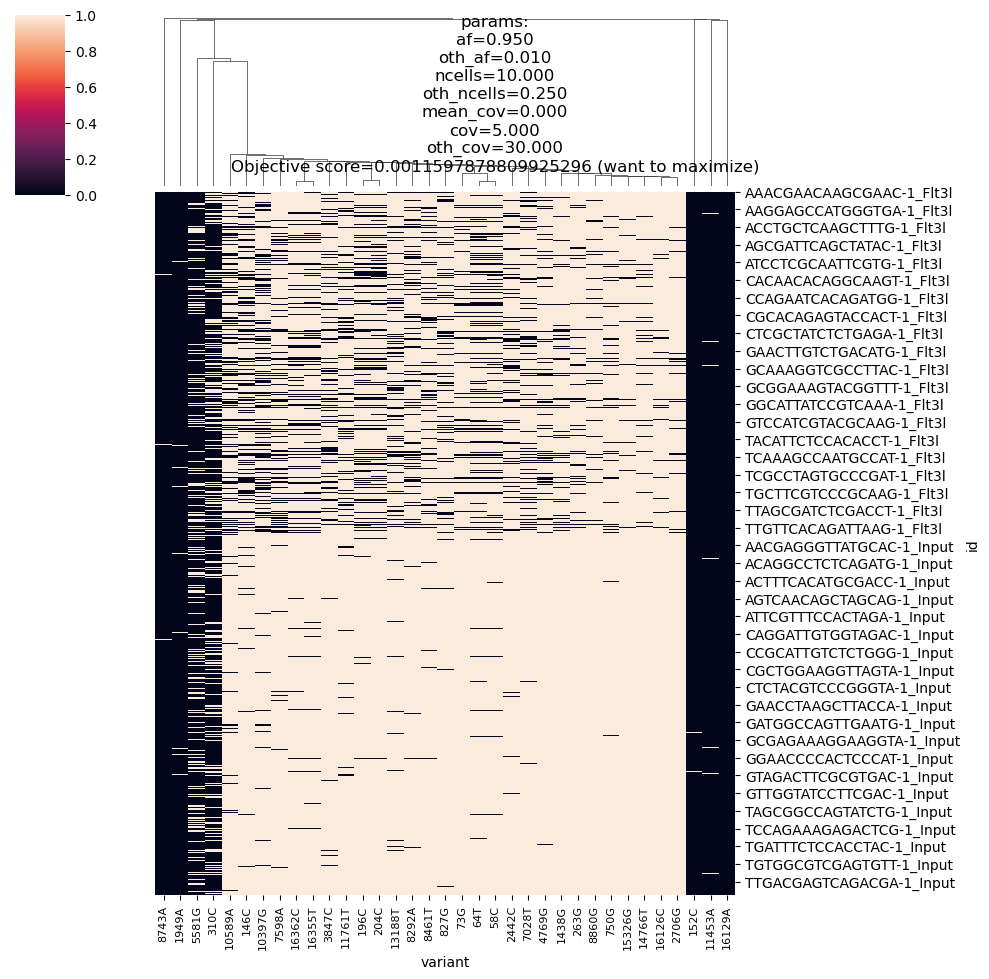

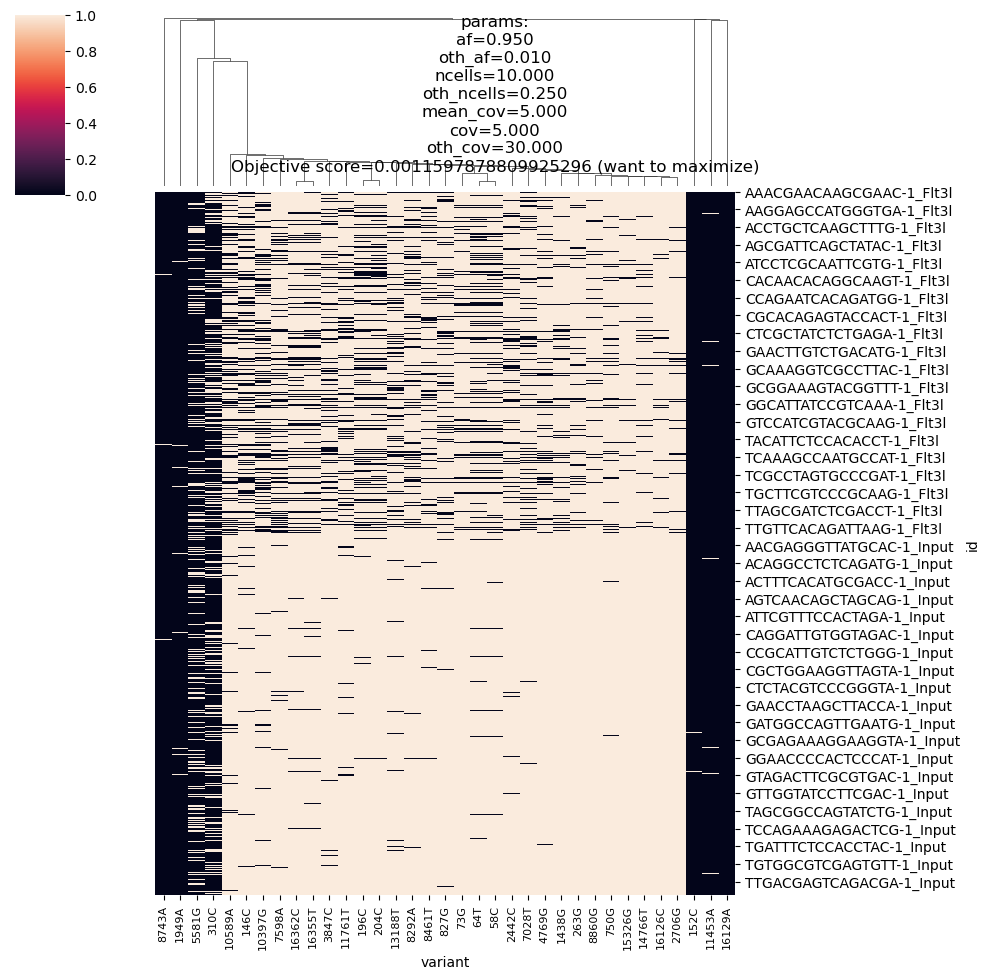

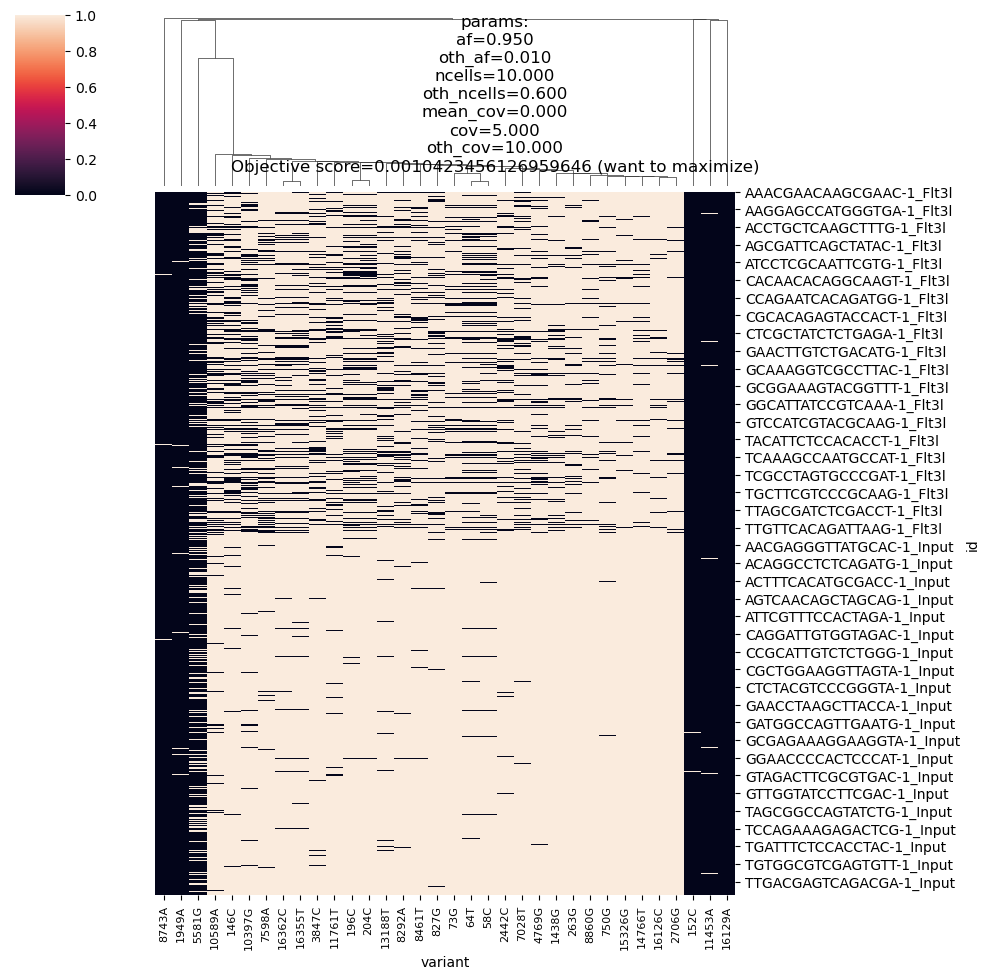

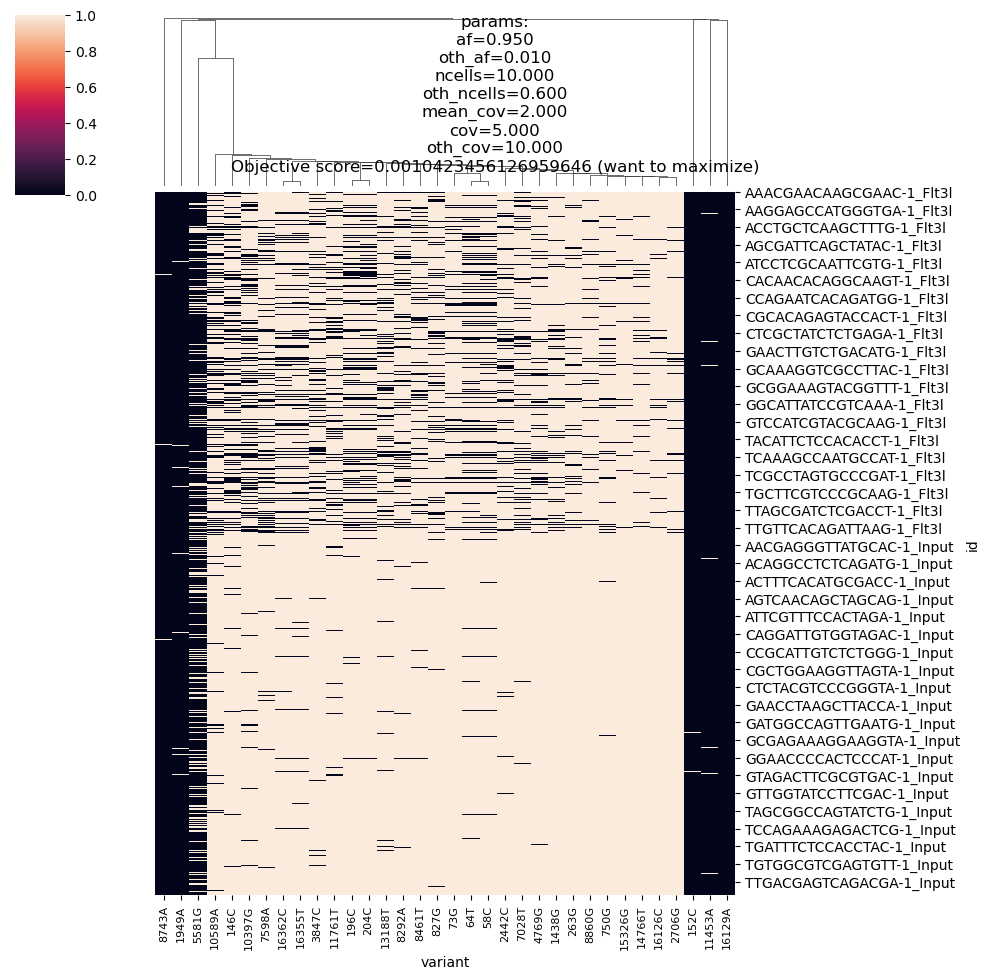

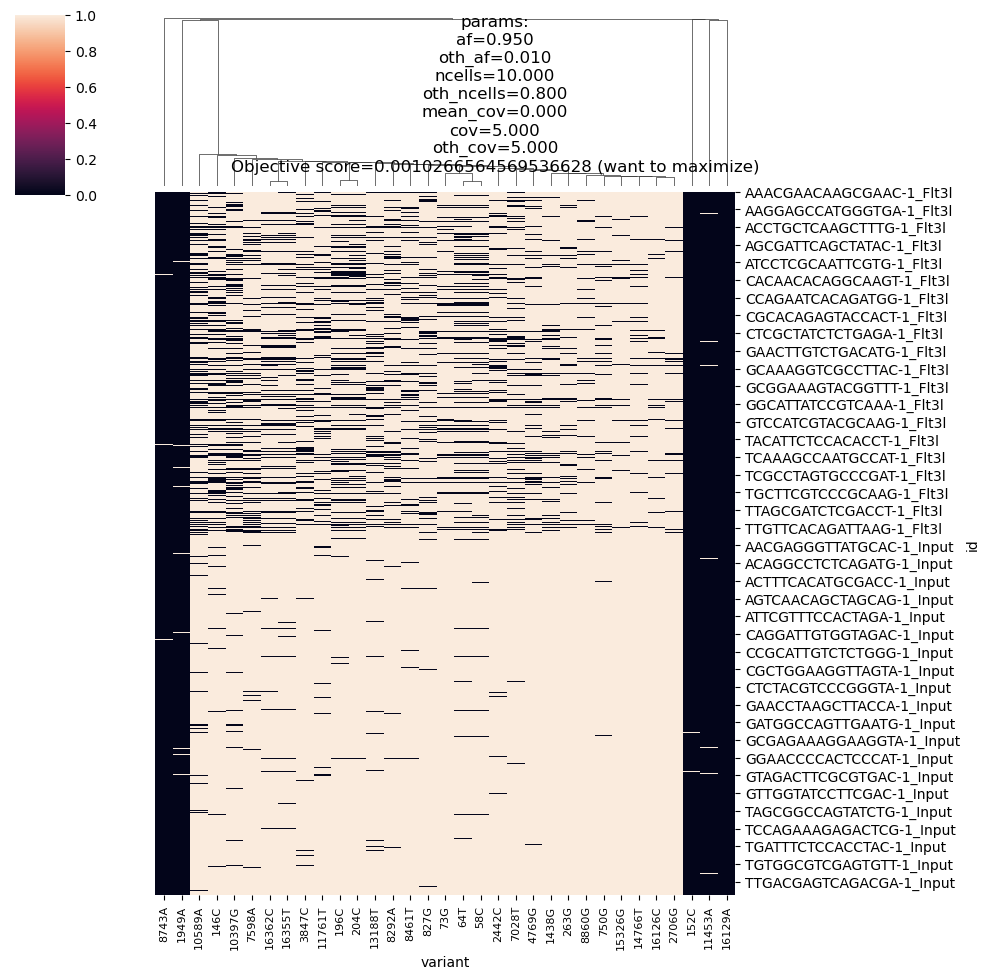

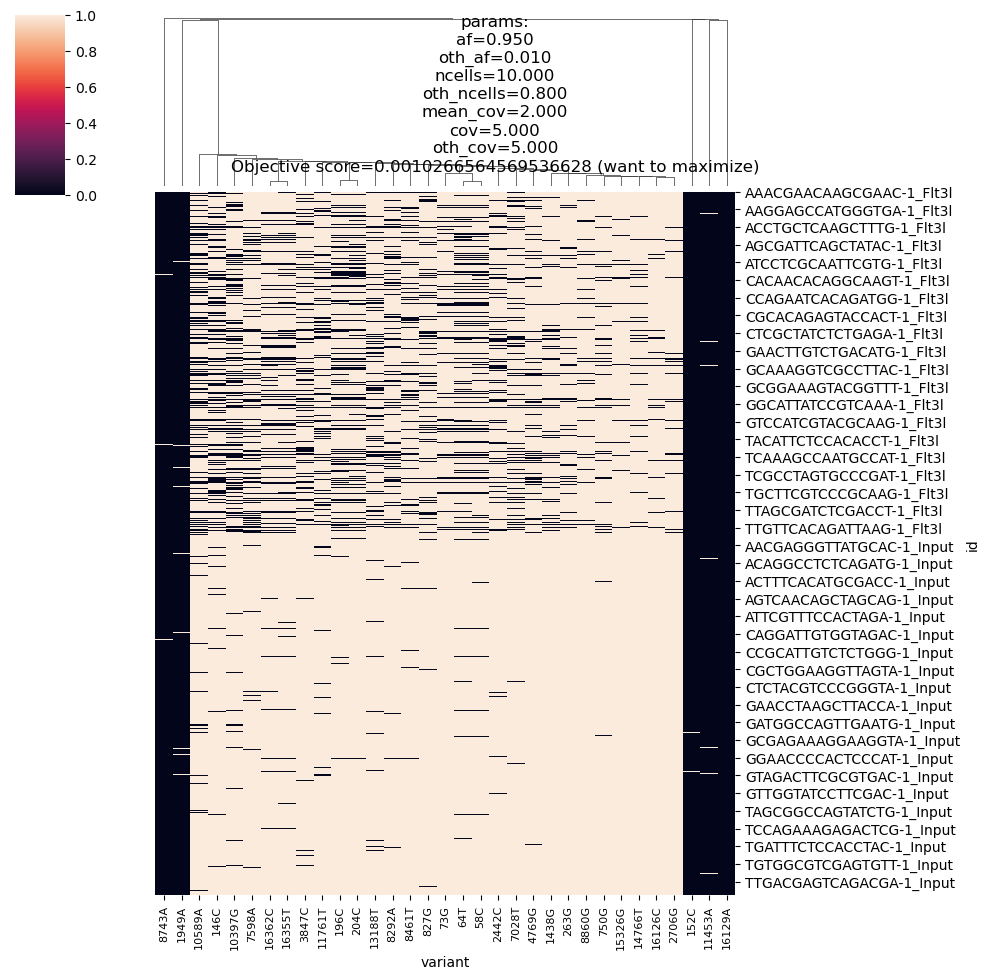

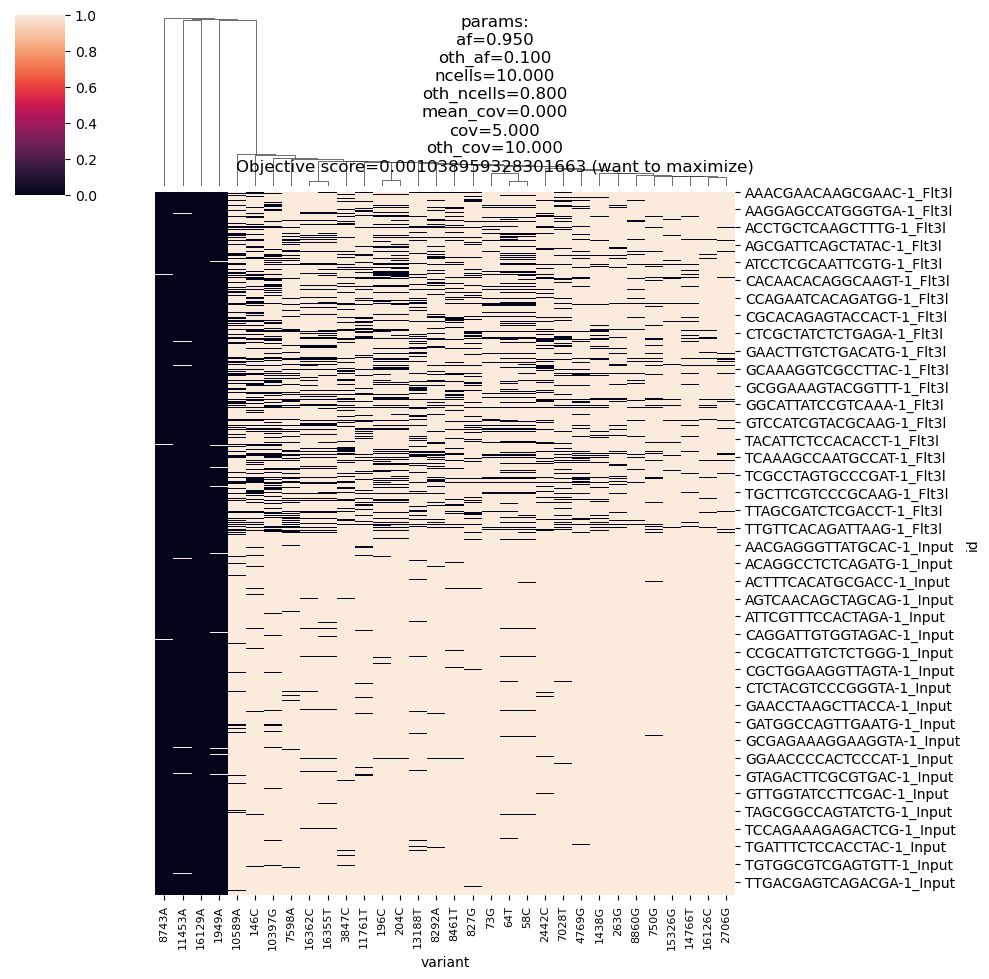

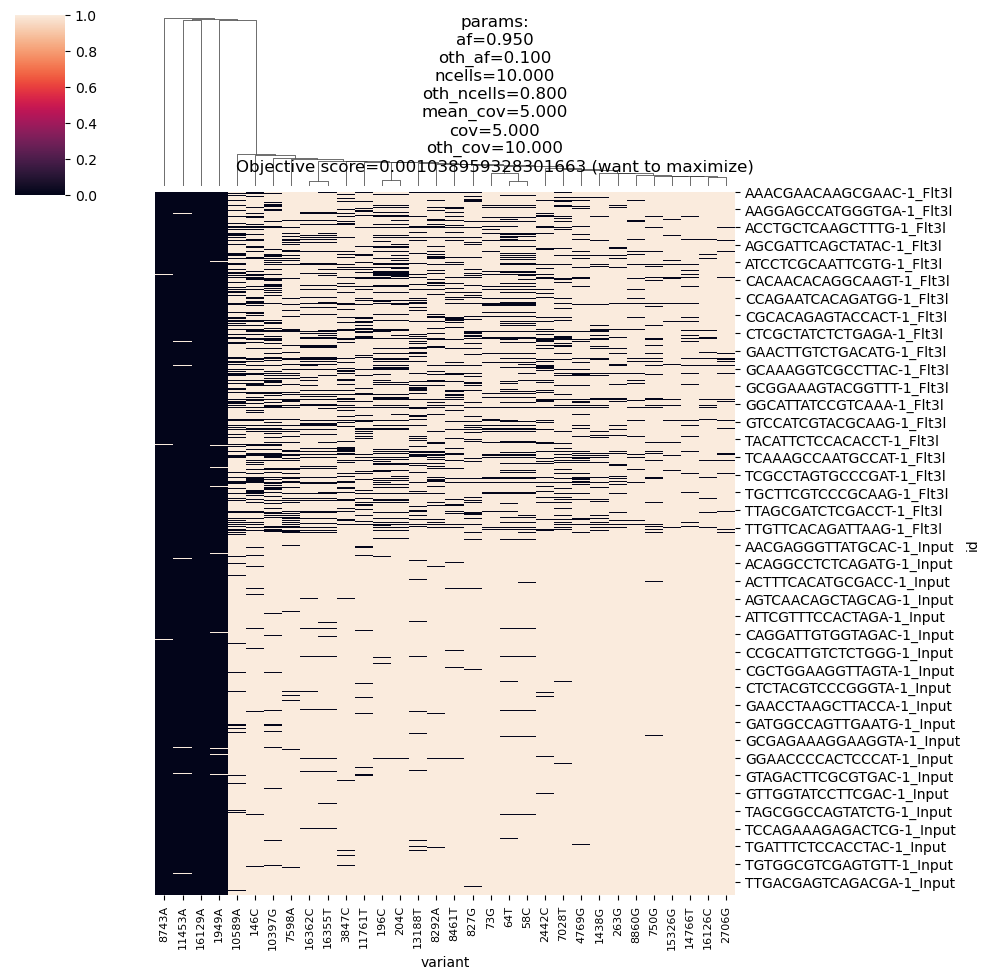

In [106]:
for ind, val in all_df.groupby("ID"):
    print('ind', ind)
    val = val.fillna(0).loc[~(val == 0).all(axis=1)].loc[:, ~(val == 0).all()]
    print(val.shape)
    meta_df = val.apply(lambda x: filt_results.loc[ind], axis=1, result_type='expand')
    g = ch.plot_cluster(df=val.drop("ID", axis=1).fillna(0).astype(int), 
                        to_row_clust=True, to_col_clust=True,
                        metric='jaccard')
    g.fig.suptitle(filt_results.loc[ind, "params_multi"])

In [ ]:
clusters, link = create_dendro(val, minClusterSize=3)
clusters.unique()

distances
[0.20689655 0.5        0.4137931  ... 0.03448276 0.         0.03448276]
link
[[1.39600000e+03 1.47300000e+03 0.00000000e+00 2.00000000e+00]
 [5.45000000e+02 3.63000000e+03 0.00000000e+00 2.00000000e+00]
 [6.47000000e+02 7.39000000e+02 0.00000000e+00 2.00000000e+00]
 ...
 [1.39940000e+04 1.39990000e+04 7.28228204e-01 6.99700000e+03]
 [1.39860000e+04 1.40000000e+04 7.34789941e-01 7.00100000e+03]
 [2.90500000e+03 1.40010000e+04 8.59989370e-01 7.00200000e+03]]
..cutHeight not given, setting it to 0.8513894762587263  ===>  99% of the (truncated) height range in dendro.


In [ ]:
fg = sns.FacetGrid(data=all_df, height=4, sharey=False, sharex=False,
                   col="id", col_wrap=4, col_order=filt_results["params"].values, margin_titles=True)

fg.map_dataframe(optim.draw_heatmap, 'variant','clone', 'log2_n_cells',
                 clones_order=clones_order, variants_order=variants_order)#, cbar=False)

#fg.set_titles(row_template = 'other_pct_thresh: {row_name}', col_template = 'pct_thresh: {col_name}')
fg.fig.suptitle(f"Best parameter combinations shown in order")
fg.fig.subplots_adjust(top=0.9, hspace = 0.8)

plt.title("multiobjective function (want to maximize)")
#plt.savefig(join(outdir, "top_param_results.pdf"))
plt.savefig(join(outdir, "top_param_results.pdf"), dpi=300)



In [25]:
#sns.clustermap(all_df.fillna(0), metric="jaccard")

In [ ]:

heatmap_input = all_df[["n_cells", "variant"]].reset_index().pivot(index="id", columns="variant", values="n_cells").fillna(0).astype(int)
meta_df = all_df[["af_thresh", "other_pct_thresh", "pct_thresh", "clone"]]
meta_df = meta_df.loc[~(meta_df.index.duplicated())]
meta_df = meta_df.sort_values(["af_thresh","pct_thresh", "other_pct_thresh", "clone"])
heatmap_input = heatmap_input.loc[meta_df.index]

# Get the variants based on total number of cells across parameters
heatmap_input = heatmap_input.loc[:,heatmap_input.sum().sort_values()[::-1].index]
variants_order = heatmap_input.columns



In [ ]:

clone_sums = meta_df.groupby("clone").apply(optim.clone_sum, heatmap_input)
clone_sums = clone_sums.loc[:, clone_sums.sum().sort_values()[::-1].index]
clones_order = clone_sums.index

all_df["params"] = all_df.apply(optim.params_to_str, axis=1, args=(param_names,))
filt_results["params"] = filt_results.apply(optim.params_to_str, axis=1, args=(param_names,))
filt_results["params_multi"] = filt_results.apply(optim.params_and_multi_str, axis=1)
tmp = filt_results.set_index("params")
all_df["multi_obj"] = all_df.apply(lambda x: tmp.loc[x["params"], "multi_obj"], axis=1)
del tmp

all_df["params_multi"] = all_df.apply(optim.params_and_multi_str, axis=1)


fg = sns.FacetGrid(data=all_df.reset_index(), height=4, sharey=False, sharex=False,
                   col="params", col_wrap=4, col_order=filt_results["params"].values, margin_titles=True)

fg.map_dataframe(optim.draw_heatmap, 'variant','clone', 'log2_n_cells',
                 clones_order=clones_order, variants_order=variants_order)#, cbar=False)

#fg.set_titles(row_template = 'other_pct_thresh: {row_name}', col_template = 'pct_thresh: {col_name}')
fg.fig.suptitle(f"Best parameter combinations shown in order")
fg.fig.subplots_adjust(top=0.9, hspace = 0.8)

plt.title("multiobjective function (want to maximize)")
#plt.savefig(join(outdir, "top_param_results.pdf"))
plt.savefig(join(outdir, "top_param_results.pdf"), dpi=300)



In [21]:
val = full_params_df.sample(1).iloc[0]
val
out_param_run = evaluate_series(val, curr_af, curr_cov, return_data=True, get_dendro="cv")
out_param_run

before remove 0 filter (7002, 196)
after (7002, 59)


{'objectives': n_cells_obs    7002.000000
 n_vars_obs       59.000000
 cov               2.000000
 oth_cov          10.000000
 af                0.010000
 oth_af            0.950000
 ncells           10.000000
 oth_ncells        0.800000
 cv               28.598772
 dtype: float64,
 'binary_df':                           13188T  4917G  1438G  5581G  16519C   73G  5147A  \
 Cell                                                                         
 AAACGAACAAGCGAAC-1_Flt3l    True  False   True   True   False  True   True   
 AAACGAACACAGCCAC-1_Flt3l    True  False   True   True   False  True  False   
 AAACGAACACAGGTAG-1_Flt3l    True  False  False   True   False  True  False   
 AAACGAACATAGAATG-1_Flt3l   False  False   True   True   False  True  False   
 AAACGAAGTATTCGAC-1_Flt3l    True  False   True   True   False  True  False   
 ...                          ...    ...    ...    ...     ...   ...    ...   
 TTTGTGTGTAGGGTCA-1_Input    True  False   True  False   False  True  Fa

In [22]:
out_param_run["objectives"]

n_cells_obs    7002.000000
n_vars_obs       59.000000
cov               2.000000
oth_cov          10.000000
af                0.010000
oth_af            0.950000
ncells           10.000000
oth_ncells        0.800000
cv               28.598772
dtype: float64

In [23]:
#pd.DataFrame(results_df)

In [24]:
results_df.head()

n_cells_obs  n_vars_obs   cov  oth_cov   af  oth_af  ncells  \
5157        7002.0        68.0   5.0      5.0  0.1    0.01    10.0   
4846        5036.0        85.0  30.0     10.0  0.1    0.01     5.0   
15764       7002.0        30.0   5.0      2.0  0.8    0.10     0.1   
9400        6977.0        23.0  10.0      2.0  0.1    0.95     0.2   
14558         80.0         4.0  30.0     10.0  0.8    0.01     5.0   

       oth_ncells         cv  
5157         0.80  39.877589  
4846         0.25  63.012711  
15764        0.25   2.926153  
9400         0.80   4.079989  
14558        0.80   3.025316

In [25]:
all_objectives

['n_vars_obs',
 'n_cells_obs',
 'cov',
 'oth_cov',
 'af',
 'oth_af',
 'ncells',
 'oth_ncells',
 'variant_coefficient_variation']

In [26]:
all_weights

[1, 1, 1, 1, 1, -1, 1, 1, 1]

In [27]:
from dynamicTreeCut import cutreeHybrid
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage
distances = pdist(curr_df.values,
                  metric="jaccard")


NameError: name 'curr_df' is not defined

In [ ]:

for ind, val in tqdm(full_params_df.iterrows()):
    # get boolean variant array and keep the ones that are true
    curr_vars, curr_cells_vars_d = evaluate_series(val, curr_af, curr_cov)

In [ ]:
sns.distplot(results_norm["multi"])

In [ ]:
sns.clustermap(results_norm.drop("multi", axis=1))

In [ ]:
sns.clustermap(results_norm, row_cluster=False)

In [ ]:
sns.clustermap(rank_df.drop("multi", axis=1))

In [ ]:

# seen_variants = params_results["Variants"].dropna().apply(lambda x: x.split(";"))
# params_results["Variants List"] = seen_variants
# seen_variants = set(sum(list(seen_variants.values), []))

# params_results["n_vars"] = params_results["Variants List"].apply(lambda x: len(x) if type(x) is list else 0)

# ## Save
# params_results.drop("Variants List", axis=1).to_csv(join(outdir, f"donor_{d}_thresh_results.tsv"), sep="\t", index=False)

# if to_plots:
#     plots(params_results,outdir, prefix=f"donor_{d}")



## Check subset variants

## For each thresh get the variants and other and output the list of cells

In [ ]:
for d in don_dirs: 
    curr_af, curr_cov, curr_cells_meta, curr_variants = load_donor(don_dirs[d])
    if curr_af.shape[0] == 0:
        continue
    curr_cov_name = curr_cov.copy()   
    curr_cov_name.index = "COV-" + curr_cov.index
    curr_af_cov = pd.concat([curr_af, curr_cov_name], verify_integrity=True, sort=False)

    params_results = pd.read_csv(join(outdir, f"donor_{d}_thresh_results.tsv"), sep="\t")
    for thresh, curr_df in params_results.groupby(["af", "oth_af", "cov", "oth_cov"]):
        print(thresh)
        # get all variants seen here:
        curr_vars = set()
        for x in curr_df["Variants"].dropna().values:
            curr_vars = curr_vars.union(set(x.split(";")))
        
        curr_cells_vars_d = {}
        for c_var in curr_vars: #curr_af.columns:
            pos_af = curr_af[c_var]
            pos_cov = curr_cov[c_var]
            curr_cells_vars_d[c_var] = get_cells(*(thresh), pos_af, pos_cov)
        curr_f = join(cells_dir, f"don.{d}_af.{thresh[0]}_othaf.{thresh[1]}_cov.{thresh[2]}_othcov.{thresh[3]}.p")
        pickle.dump(curr_cells_vars_d, open(curr_f,'wb'))

In [ ]:
params_results.sort_values("n_vars", ascending=False)

In [ ]:
cmd = f"touch {outdir}/.complete"
!{cmd}

## For each pairwise variants check if the cells with the variant (and coverage) is over 50%, if it is remove the smaller one (create tree)